# Introduction
FEVO interview data scientist challenge

### Imports
Import libraries and write settings here.

In [268]:
# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import date
from collections import Counter

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly as py
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

# # mlxtend library for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# liftimes module for CLV models
import lifetimes

# scikit learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score, roc_curve, accuracy_score, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


### Import data

In [143]:
# Order data
order_data_ = pd.read_csv("../data/raw/order_data.csv")
print(order_data_.shape)
order_data_.head()

(100, 24)


,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb
0,0227fb74-6fef-4705-93d3-267ea8c223ac,3J5VKYMIKZ,1,2021-05-14 00:11:47.42191+00,100,4.38000,4.68000,0,109.06000,True,10906,False,NaN,NaN,20210514001013249-Q175Xwh9gpaGskvABkJwxq,40,female,29000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Lynch's Team,NY,US,Desktop,"[{""id"": ""oli-BkGazB3VRPkDA7Tb3vGf43"", ""price"":..."
1,08383211-31c7-41e8-af62-040ab57bef91,MVZKEXZSDU,1,2021-05-28 00:07:40.913547+00,500,0.00000,9.52000,0,509.52000,True,50952,False,NaN,NaN,20210528000605652-Un6WDdXuj76sDYpMzbkawK,45,female,107000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Psycho's Group,NY,US,Desktop,"[{""id"": ""oli-VJKa2uJG8CXEJW8MxNYjG8"", ""price"":..."
2,09cec2ef-f47d-4529-9efc-4eb566f7fb50,A747ETYTIC,1,2021-05-04 10:18:26.465221+00,110,0.00000,54.63000,0,164.63000,True,16463,False,NaN,NaN,20210504101656950-RfopULDB5fK7G8AWXuTnKd,40,male,45000,grp-09b1da02-2347-4e94-a085-a2abbcfeeb9c--good...,Scar's Familia,SK,MK,Desktop,"[{""id"": ""oli-XuWxxvdru5i4nN89vvdKht"", ""price"":..."
3,0c0278ee-9754-47ff-a898-3d56e140f82b,HZ7KBD2,1,2021-04-16 00:05:23.058775+00,110,9.76000,5.98000,0,125.74000,True,12574,False,NaN,NaN,20210415235313985-JW3kmgjjyyFd3sPh8aQC7j,34,female,119000,grp-2c9721c6-26bb-46cc-b666-5b038df57b84--good...,Colt's Winners,NY,US,Mobile,"[{""id"": ""oli-RFy1mAqazJVNdgQ842EiHe"", ""price"":..."
4,0e3fafb7-cd99-4052-8315-056f1446301d,9HZUUSGPFZ,1,2021-04-27 20:56:05.03676+00,110,0.00000,2.46000,0,113.46000,True,11346,False,NaN,NaN,20210401153734568-5uMfDDzFxZs6imnFWABG4o,41,female,117000,grp-24f6a18e-8bb9-43af-9137-9b0e82cc0c98--good...,Rigs's Group,CA,US,Desktop,"[{""id"": ""oli-Gr1QeqP7RFzbKpzGX3KyVB"", ""price"":..."


In [3]:
# Order with product sold denormalized data
order_with_product_ = pd.read_csv("../data/raw/order_with_product_sold.csv")
print(order_with_product_.shape)
order_with_product_.head()

(186, 29)


,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,price,product_id,product_title,product_variant_id,product_variant_title
0,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
2,10ef2c45-cb42-41ec-82ea-6e241a205021,RF5LR2UURJ,2,2021-04-27 13:04:26.70683+00,100,0.00000,4.68000,0,0.00000,True,10468,False,10468.00000,2021-04-27 13:09:35.607894+00,20210427130320635-Xo7MTkGzMZHKu6APFBHuja,27,male,42000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Ranger's Team,NY,US,Desktop,"[{""id"": ""oli-CLXZp7xNbgpjcSKU4WKXwe"", ""price"":...",100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
3,3c6a5fd9-5e57-4cf1-9ed1-332a2117dfcb,2EWVBFAYGR,1,2021-04-28 13:21:45.829622+00,100,4.88000,4.68000,0,109.56000,True,10956,False,NaN,NaN,20210428123305906-K5rxcBo3Q2uMwjD6H4mwq5,45,male,79000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Mad Dog's Group,NY,US,Desktop,"[{""id"": ""oli-MLSxCZcLySaMWHPmtLkDDJ"", ""price"":...",100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
4,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium


In [4]:
# product sold data
product_sold_ = pd.read_csv("../data/raw/product_sold.csv")
print(product_sold_.shape)
product_sold_.head()

(185, 7)


,id,order_number,price,product_id,product_title,product_variant_id,product_variant_title
0,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
2,f2fb6009-3cf4-4795-b5b8-2f66721b243f,RF5LR2UURJ,100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
3,10ef2c45-cb42-41ec-82ea-6e241a205021,RF5LR2UURJ,100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
4,3c6a5fd9-5e57-4cf1-9ed1-332a2117dfcb,2EWVBFAYGR,100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium


# EDA, data prep

Spot-checking distributions
- Checking for extreme values
- Checking for negative values

## order_data

In [144]:
order_data = order_data_.copy()

In [145]:
# Describe data
order_data.describe()

,order_revision,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,charged_amount,refunded_amount,age,income
count,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,4.00000,100.00000,100.00000
mean,1.06000,192.55000,6.74510,10.12290,0.00000,198.39580,20951.80000,19341.50000,39.25000,76790.00000
std,0.23868,204.79541,18.06084,13.52626,0.00000,224.92137,22231.53015,19885.53923,10.64522,23773.46581
min,1.00000,30.00000,0.00000,0.00000,0.00000,0.00000,3385.00000,5598.00000,10.00000,22000.00000
25%,1.00000,100.00000,0.00000,4.68000,0.00000,104.68000,10468.00000,9250.50000,32.00000,60000.00000
50%,1.00000,110.00000,0.00000,5.98000,0.00000,113.68000,12361.00000,11456.00000,38.00000,77500.00000
75%,1.00000,220.00000,9.76000,9.52000,0.00000,229.26000,24904.00000,21547.00000,45.00000,93750.00000
max,2.00000,1700.00000,150.90000,57.52000,0.00000,1860.42000,186042.00000,48856.00000,69.00000,126000.00000


Spot-checking null values 
- Ensure that order_number, orderlineitems not missing because this would prohibit building an order basket

In [7]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     100 non-null    object 
 1   order_number           100 non-null    object 
 2   order_revision         100 non-null    int64  
 3   order_created_at_utc   100 non-null    object 
 4   sub_total_amount       100 non-null    int64  
 5   tax_total_amount       100 non-null    float64
 6   shipping_total_amount  100 non-null    float64
 7   fee_total_amount       100 non-null    int64  
 8   order_total_amount     100 non-null    float64
 9   requires_payment       100 non-null    bool   
 10  charged_amount         100 non-null    int64  
 11  charge_refunded        100 non-null    bool   
 12  refunded_amount        4 non-null      float64
 13  refunded_at_utc        6 non-null      object 
 14  customer_id            100 non-null    object 
 15  age    

**It seems some orders were refunded/returned. Let's exclude these from analysis since there's few of them and they do not really add information to what we need to know. However, a future analysis (with more data) could be to look at factors associated with returns/refunds.**

In [146]:
order_data = order_data[order_data["refunded_at_utc"].isnull()] # drop refunded orders

In [9]:
print(order_data.shape)
order_data.isnull().sum()

(94, 24)


id                        0
order_number              0
order_revision            0
order_created_at_utc      0
sub_total_amount          0
tax_total_amount          0
shipping_total_amount     0
fee_total_amount          0
order_total_amount        0
requires_payment          0
charged_amount            0
charge_refunded           0
refunded_amount          94
refunded_at_utc          94
customer_id               0
age                       0
gender                    0
income                    0
group_id                  0
group_name                6
customer_state            8
customer_country          6
device_type               0
orderlineitems_jsonb      0
dtype: int64

Are there duplicates?

In [147]:
duplicates = order_data[order_data.duplicated(["id","order_number"])]
print(duplicates.shape)
duplicates.head()

(1, 24)


,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb
96,fd9df330-0b7e-47de-850a-578c1666a4fa,169NPU5TSH,1,2021-04-27 23:31:19.997899+00,100,0.00000,4.68000,0,104.68000,True,10468,False,NaN,NaN,20210427232749440-83MDMhELkrpn6hrWbcJSxM,60,female,43000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Sasquatch's Familia,NY,US,Desktop,"[{""id"": ""oli-WdRhhGLe7z4SvgPfbjrDPS"", ""price"":..."


Drop 1 duplicate record based on ID and order number

In [148]:
order_data = order_data.drop_duplicates(subset=["id","order_number"])
print(order_data.shape)
order_data.head()

(93, 24)


,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb
0,0227fb74-6fef-4705-93d3-267ea8c223ac,3J5VKYMIKZ,1,2021-05-14 00:11:47.42191+00,100,4.38000,4.68000,0,109.06000,True,10906,False,NaN,NaN,20210514001013249-Q175Xwh9gpaGskvABkJwxq,40,female,29000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Lynch's Team,NY,US,Desktop,"[{""id"": ""oli-BkGazB3VRPkDA7Tb3vGf43"", ""price"":..."
1,08383211-31c7-41e8-af62-040ab57bef91,MVZKEXZSDU,1,2021-05-28 00:07:40.913547+00,500,0.00000,9.52000,0,509.52000,True,50952,False,NaN,NaN,20210528000605652-Un6WDdXuj76sDYpMzbkawK,45,female,107000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Psycho's Group,NY,US,Desktop,"[{""id"": ""oli-VJKa2uJG8CXEJW8MxNYjG8"", ""price"":..."
2,09cec2ef-f47d-4529-9efc-4eb566f7fb50,A747ETYTIC,1,2021-05-04 10:18:26.465221+00,110,0.00000,54.63000,0,164.63000,True,16463,False,NaN,NaN,20210504101656950-RfopULDB5fK7G8AWXuTnKd,40,male,45000,grp-09b1da02-2347-4e94-a085-a2abbcfeeb9c--good...,Scar's Familia,SK,MK,Desktop,"[{""id"": ""oli-XuWxxvdru5i4nN89vvdKht"", ""price"":..."
3,0c0278ee-9754-47ff-a898-3d56e140f82b,HZ7KBD2,1,2021-04-16 00:05:23.058775+00,110,9.76000,5.98000,0,125.74000,True,12574,False,NaN,NaN,20210415235313985-JW3kmgjjyyFd3sPh8aQC7j,34,female,119000,grp-2c9721c6-26bb-46cc-b666-5b038df57b84--good...,Colt's Winners,NY,US,Mobile,"[{""id"": ""oli-RFy1mAqazJVNdgQ842EiHe"", ""price"":..."
4,0e3fafb7-cd99-4052-8315-056f1446301d,9HZUUSGPFZ,1,2021-04-27 20:56:05.03676+00,110,0.00000,2.46000,0,113.46000,True,11346,False,NaN,NaN,20210401153734568-5uMfDDzFxZs6imnFWABG4o,41,female,117000,grp-24f6a18e-8bb9-43af-9137-9b0e82cc0c98--good...,Rigs's Group,CA,US,Desktop,"[{""id"": ""oli-Gr1QeqP7RFzbKpzGX3KyVB"", ""price"":..."


Checking for skew and outliers

In [12]:
order_data.skew()

order_revision          0.00000
sub_total_amount        4.43992
tax_total_amount        5.83517
shipping_total_amount   2.47342
fee_total_amount        0.00000
order_total_amount      4.54059
requires_payment        0.00000
charged_amount          4.54059
charge_refunded         0.00000
refunded_amount             NaN
refunded_at_utc             NaN
age                     0.28396
income                  0.00325
dtype: float64

Let's look at the distributions of the skewed features to see about outliers

<Figure size 1152x1440 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount'>

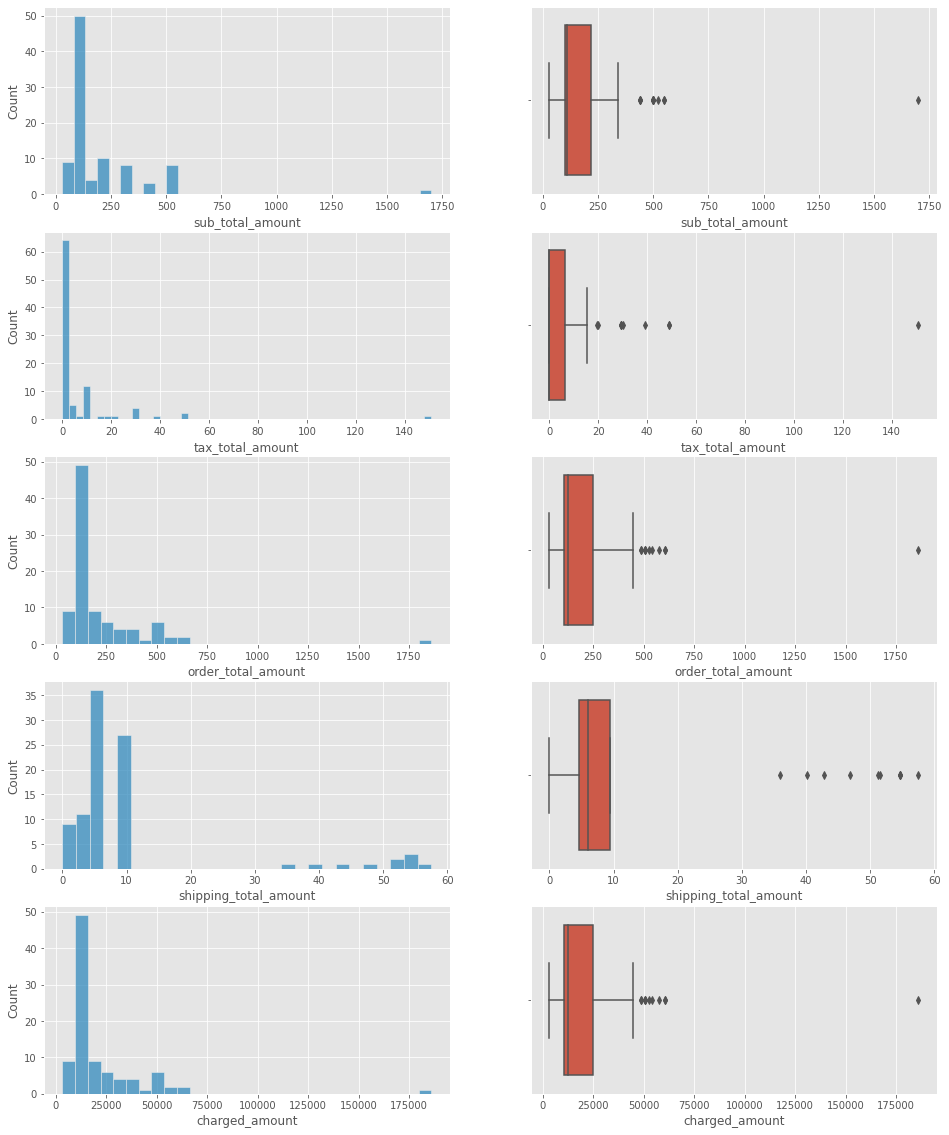

In [14]:
plt.figure(figsize=(16,20))
plt.subplot(5,2,1)
sns.histplot(order_data['sub_total_amount'])
plt.subplot(5,2,2)
sns.boxplot(order_data['sub_total_amount'])
plt.subplot(5,2,3)
sns.histplot(order_data['tax_total_amount'])
plt.subplot(5,2,4)
sns.boxplot(order_data['tax_total_amount'])
plt.subplot(5,2,5)
sns.histplot(order_data['order_total_amount'])
plt.subplot(5,2,6)
sns.boxplot(order_data['order_total_amount'])
plt.subplot(5,2,7)
sns.histplot(order_data['shipping_total_amount'])
plt.subplot(5,2,8)
sns.boxplot(order_data['shipping_total_amount'])
plt.subplot(5,2,9)
sns.histplot(order_data['charged_amount'])
plt.subplot(5,2,10)
sns.boxplot(order_data['charged_amount'])
plt.savefig('../reports/figures/original_distribution.png')
plt.show()

Based on skewness and distributions it appears sub total amount, tax total amount, shipping total amount, order total amount, and charged amount have outliers. Will threshold these outliers so they do not unfairly bias future models using these features

In [149]:
# Since distributions are skewed we will use interquartile range to threshold outliers
# setting threshold to be 1.5 above and below IQR
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [150]:
col_list = ["sub_total_amount", "tax_total_amount", "order_total_amount", "shipping_total_amount", "charged_amount"]
for col in col_list:
    replace_with_thresholds(order_data, col)

<Figure size 1152x1440 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount'>

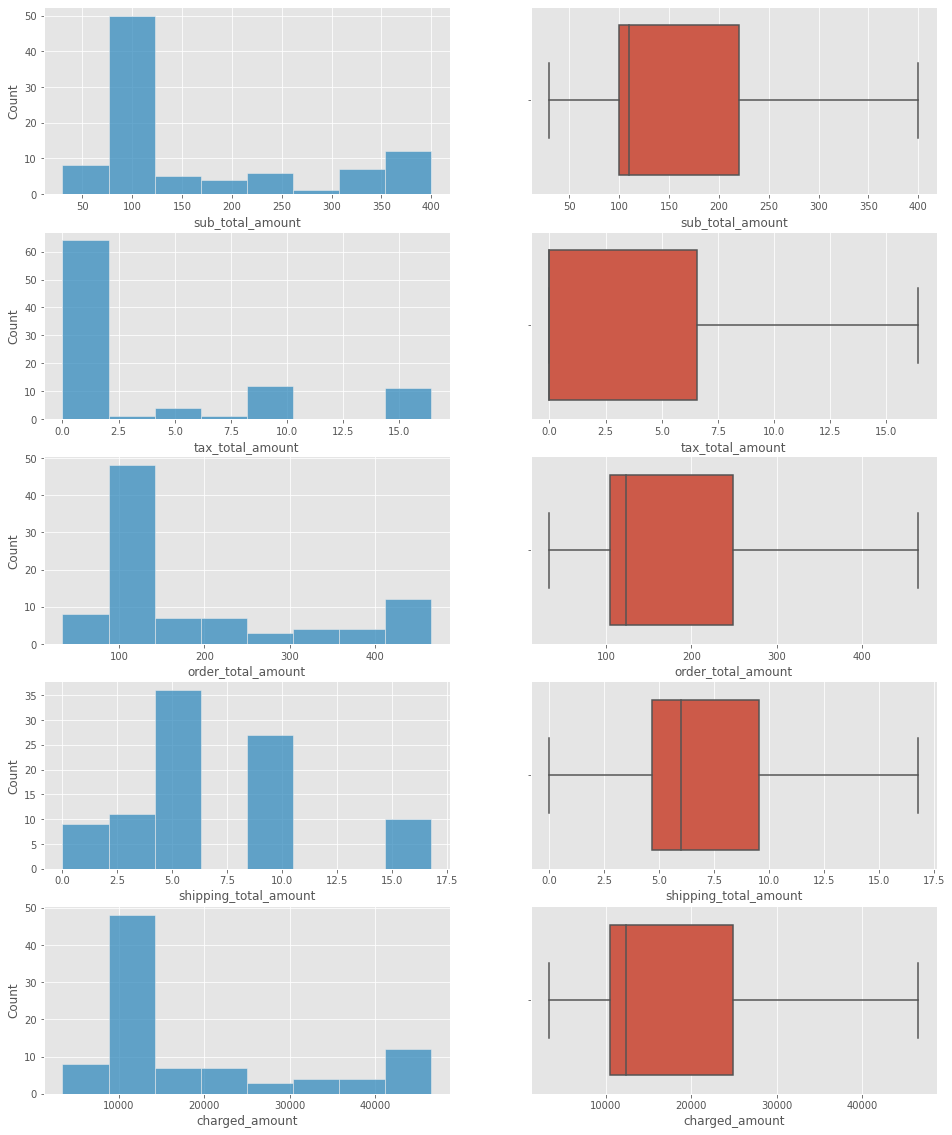

In [17]:
plt.figure(figsize=(16,20))
plt.subplot(5,2,1)
sns.histplot(order_data['sub_total_amount'])
plt.subplot(5,2,2)
sns.boxplot(order_data['sub_total_amount'])
plt.subplot(5,2,3)
sns.histplot(order_data['tax_total_amount'])
plt.subplot(5,2,4)
sns.boxplot(order_data['tax_total_amount'])
plt.subplot(5,2,5)
sns.histplot(order_data['order_total_amount'])
plt.subplot(5,2,6)
sns.boxplot(order_data['order_total_amount'])
plt.subplot(5,2,7)
sns.histplot(order_data['shipping_total_amount'])
plt.subplot(5,2,8)
sns.boxplot(order_data['shipping_total_amount'])
plt.subplot(5,2,9)
sns.histplot(order_data['charged_amount'])
plt.subplot(5,2,10)
sns.boxplot(order_data['charged_amount'])
plt.savefig('../reports/figures/outliers_removed_distributions.png')
plt.show()

We've now truncated our outliers, but these distributions are still non-normal. When we build models later for purchase probability, etc. it's a good idea to standardize these distributions and/or transform into a normal (or some known parametric distribution). 

Many models, notably logistic and linear regression, are mathematically based on the assumption of a bivariate or multivariate normal distributions, although linear is known to still work well as long as the model errors are normally distributed and not necessarily the data itself. 

Even though some ML models, such as decision tree and XGBoost, do not have the assumption of normality and still work well on raw data, it's generally a good idea to expore data to understand the underlying distributions to make sure they fit the assumptions of any of the models under consideration. Even more complex neural network type model architectures often still rely out logistic or linear output activation functions that would be more mathematically performant under the assumption of gaussian data structures. 

Moral of the story: know your data because garbage in = garbage out. :-)


In [19]:
#Check distributions after transformation
order_data.describe().T

,count,mean,std,min,25%,50%,75%,max
order_revision,93.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000
sub_total_amount,93.00000,170.05376,114.73622,30.00000,100.00000,110.00000,220.00000,400.00000
tax_total_amount,93.00000,3.49849,5.78634,0.00000,0.00000,0.00000,6.57000,16.42500
shipping_total_amount,93.00000,6.89817,4.54089,0.00000,4.68000,5.98000,9.52000,16.78000
fee_total_amount,93.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
order_total_amount,93.00000,189.51903,132.41415,33.85000,104.68000,123.61000,249.04000,465.58000
charged_amount,93.00000,18951.90323,13241.41516,3385.00000,10468.00000,12361.00000,24904.00000,46558.00000
refunded_amount,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,93.00000,38.81720,10.35872,10.00000,32.00000,37.00000,45.00000,69.00000
income,93.00000,77204.30108,23737.49517,22000.00000,61000.00000,78000.00000,96000.00000,126000.00000


## denormalized data

In [20]:
order_denorm = order_with_product_.copy()

In [21]:
# Describe data
order_denorm.describe()

,order_revision,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,charged_amount,refunded_amount,age,income,price
count,186.00000,186.00000,186.00000,186.00000,186.00000,186.00000,186.00000,8.00000,186.00000,186.00000,186.00000
mean,1.06452,294.38172,11.46022,13.29935,0.00000,303.22495,31920.58065,28691.50000,39.46774,77344.08602,104.38172
std,0.24633,289.23154,26.95656,15.22884,0.00000,320.20000,31404.15938,21676.60007,9.89794,23464.74970,52.58732
min,1.00000,30.00000,0.00000,0.00000,0.00000,0.00000,3385.00000,5598.00000,10.00000,22000.00000,25.00000
25%,1.00000,110.00000,0.00000,4.68000,0.00000,109.17500,11000.00000,9250.50000,34.00000,63250.00000,100.00000
50%,1.00000,210.00000,0.00000,9.52000,0.00000,209.52000,21678.00000,30650.00000,37.00000,78000.00000,100.00000
75%,1.00000,440.00000,9.76000,9.52000,0.00000,486.94000,48856.00000,48856.00000,45.00000,96000.00000,110.00000
max,2.00000,1700.00000,150.90000,57.52000,0.00000,1860.42000,186042.00000,48856.00000,69.00000,126000.00000,340.00000


Spot-checking null values 
- Ensure that order_number, orderlineitems not missing because this would prohibit building an order basket

In [22]:
order_denorm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     186 non-null    object 
 1   order_number           186 non-null    object 
 2   order_revision         186 non-null    int64  
 3   order_created_at_utc   186 non-null    object 
 4   sub_total_amount       186 non-null    int64  
 5   tax_total_amount       186 non-null    float64
 6   shipping_total_amount  186 non-null    float64
 7   fee_total_amount       186 non-null    int64  
 8   order_total_amount     186 non-null    float64
 9   requires_payment       186 non-null    bool   
 10  charged_amount         186 non-null    int64  
 11  charge_refunded        186 non-null    bool   
 12  refunded_amount        8 non-null      float64
 13  refunded_at_utc        12 non-null     object 
 14  customer_id            186 non-null    object 
 15  age   

It seems some orders were refunded/returned. Let's exclude these from analysis

In [23]:
order_denorm = order_denorm[order_denorm["refunded_at_utc"].isnull()] # drop refunded orders

In [24]:
print(order_denorm.shape)
order_denorm.isnull().sum()

(174, 29)


id                         0
order_number               0
order_revision             0
order_created_at_utc       0
sub_total_amount           0
tax_total_amount           0
shipping_total_amount      0
fee_total_amount           0
order_total_amount         0
requires_payment           0
charged_amount             0
charge_refunded            0
refunded_amount          174
refunded_at_utc          174
customer_id                0
age                        0
gender                     0
income                     0
group_id                   0
group_name                 7
customer_state            11
customer_country           7
device_type                0
orderlineitems_jsonb       0
price                      0
product_id                 0
product_title              0
product_variant_id         0
product_variant_title      0
dtype: int64

Checking for skew and outliers

In [25]:
order_denorm.skew()

order_revision           0.00000
sub_total_amount         3.07214
tax_total_amount         3.98043
shipping_total_amount    1.84245
fee_total_amount         0.00000
order_total_amount       3.16862
requires_payment         0.00000
charged_amount           3.16862
charge_refunded          0.00000
refunded_amount              NaN
refunded_at_utc              NaN
age                      0.39601
income                  -0.11053
price                    3.21599
dtype: float64

<Figure size 1152x1800 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='price', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='price'>

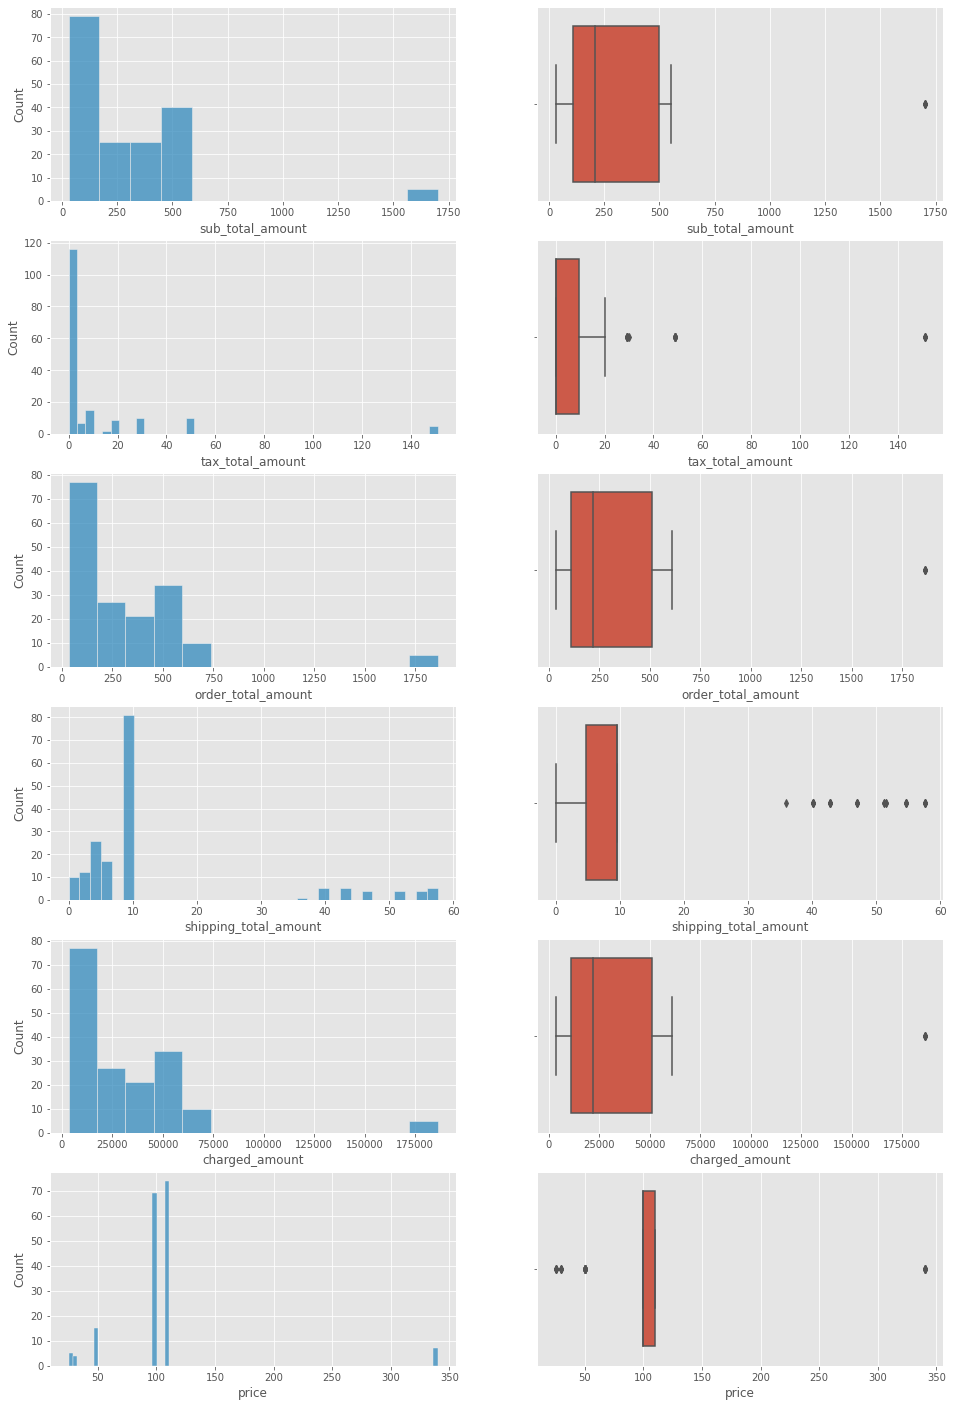

In [26]:
df = order_denorm.copy()
plt.figure(figsize=(16,25))
plt.subplot(6,2,1)
sns.histplot(df['sub_total_amount'])
plt.subplot(6,2,2)
sns.boxplot(df['sub_total_amount'])
plt.subplot(6,2,3)
sns.histplot(df['tax_total_amount'])
plt.subplot(6,2,4)
sns.boxplot(df['tax_total_amount'])
plt.subplot(6,2,5)
sns.histplot(df['order_total_amount'])
plt.subplot(6,2,6)
sns.boxplot(df['order_total_amount'])
plt.subplot(6,2,7)
sns.histplot(df['shipping_total_amount'])
plt.subplot(6,2,8)
sns.boxplot(df['shipping_total_amount'])
plt.subplot(6,2,9)
sns.histplot(df['charged_amount'])
plt.subplot(6,2,10)
sns.boxplot(df['charged_amount'])
plt.subplot(6,2,11)
sns.histplot(df['price'])
plt.subplot(6,2,12)
sns.boxplot(df['price'])
plt.savefig('../reports/figures/original_distribution_denorm.png')
plt.show()

Based on skewness and distributions it appears sub total amount, tax total, price, shipping total amount, order total amount, and charged amount have outliers. Will threshold these outliers so they do not unfairly bias future models using these features

In [671]:
col_list = ["sub_total_amount", "tax_total_amount", "order_total_amount", "shipping_total_amount", "charged_amount", "price"]
for col in col_list:
    replace_with_thresholds(order_denorm, col)

<Figure size 1152x1800 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='sub_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='tax_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='order_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='shipping_total_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='charged_amount'>

<AxesSubplot:>

<AxesSubplot:xlabel='price', ylabel='Count'>

<AxesSubplot:>

<AxesSubplot:xlabel='price'>

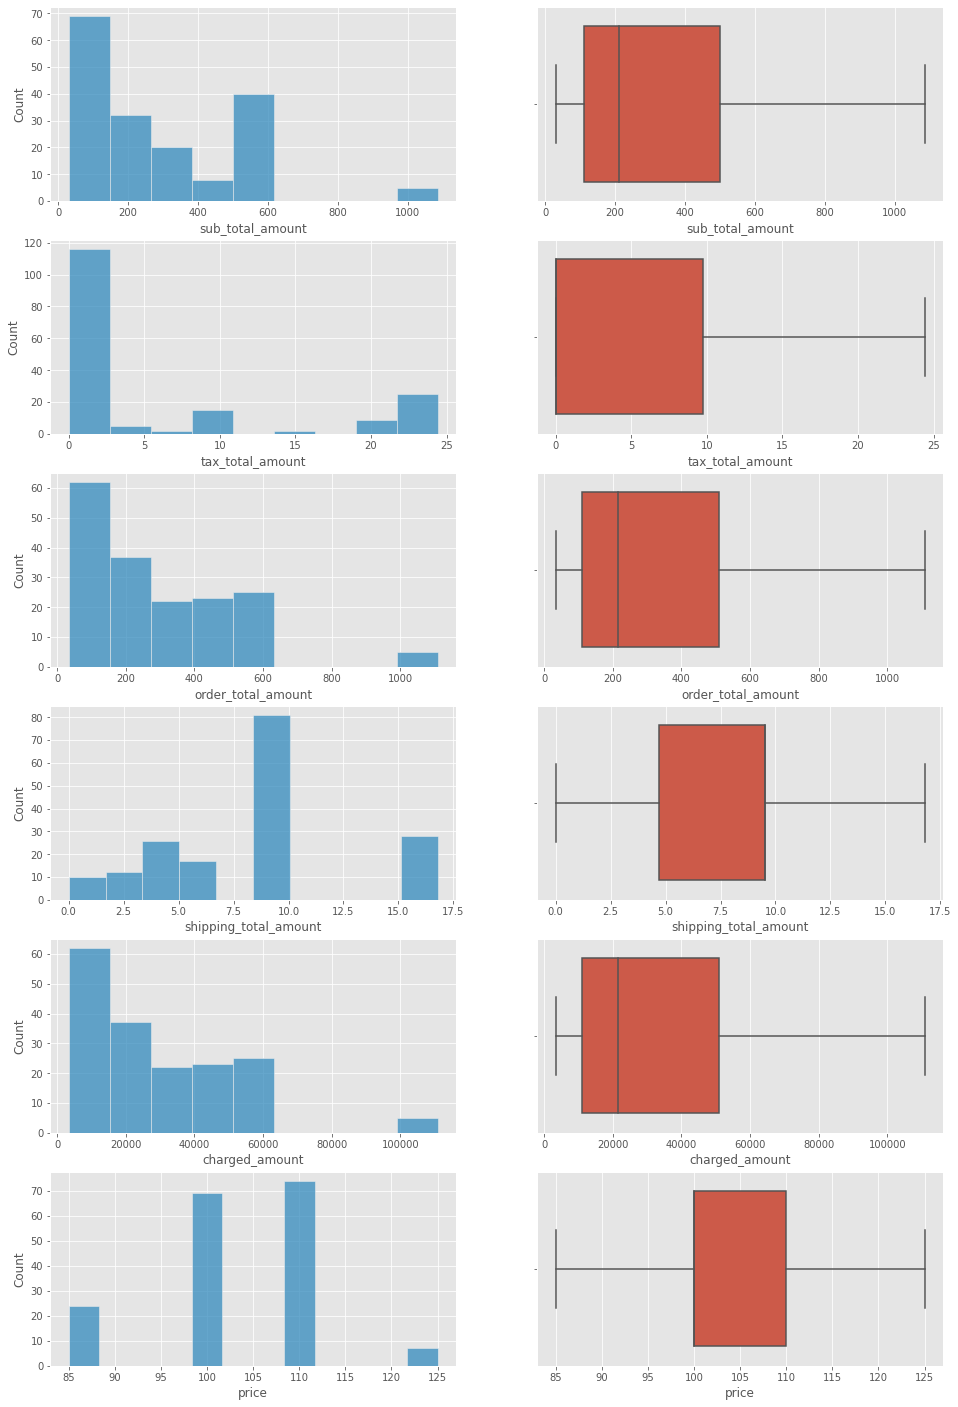

In [377]:
df = order_denorm.copy()
plt.figure(figsize=(16,25))
plt.subplot(6,2,1)
sns.histplot(df['sub_total_amount'])
plt.subplot(6,2,2)
sns.boxplot(df['sub_total_amount'])
plt.subplot(6,2,3)
sns.histplot(df['tax_total_amount'])
plt.subplot(6,2,4)
sns.boxplot(df['tax_total_amount'])
plt.subplot(6,2,5)
sns.histplot(df['order_total_amount'])
plt.subplot(6,2,6)
sns.boxplot(df['order_total_amount'])
plt.subplot(6,2,7)
sns.histplot(df['shipping_total_amount'])
plt.subplot(6,2,8)
sns.boxplot(df['shipping_total_amount'])
plt.subplot(6,2,9)
sns.histplot(df['charged_amount'])
plt.subplot(6,2,10)
sns.boxplot(df['charged_amount'])
plt.subplot(6,2,11)
sns.histplot(df['price'])
plt.subplot(6,2,12)
sns.boxplot(df['price'])
plt.savefig('../reports/figures/outliers_removed_distribution_denorm.png')
plt.show()

In [27]:
#Check distributions after transformation
order_denorm.describe().T

,count,mean,std,min,25%,50%,75%,max
order_revision,174.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000
sub_total_amount,174.00000,299.33908,295.36740,30.00000,110.00000,210.00000,500.00000,1700.00000
tax_total_amount,174.00000,11.07264,27.47286,0.00000,0.00000,0.00000,9.76000,150.90000
shipping_total_amount,174.00000,13.65632,15.67601,0.00000,4.68000,9.52000,9.52000,57.52000
fee_total_amount,174.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
order_total_amount,174.00000,324.13701,320.65909,33.85000,110.00000,216.78000,509.52000,1860.42000
charged_amount,174.00000,32413.70115,32065.90926,3385.00000,11000.00000,21678.00000,50952.00000,186042.00000
refunded_amount,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,174.00000,38.92529,9.36542,10.00000,33.00000,37.00000,44.75000,69.00000
income,174.00000,76925.28736,23717.51246,22000.00000,63000.00000,76500.00000,96750.00000,126000.00000


In [28]:
# convert order date to datetime type
order_denorm["order_created_at_utc"] = pd.to_datetime(order_denorm["order_created_at_utc"])

In [29]:
order_denorm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 185
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     174 non-null    object             
 1   order_number           174 non-null    object             
 2   order_revision         174 non-null    int64              
 3   order_created_at_utc   174 non-null    datetime64[ns, UTC]
 4   sub_total_amount       174 non-null    int64              
 5   tax_total_amount       174 non-null    float64            
 6   shipping_total_amount  174 non-null    float64            
 7   fee_total_amount       174 non-null    int64              
 8   order_total_amount     174 non-null    float64            
 9   requires_payment       174 non-null    bool               
 10  charged_amount         174 non-null    int64              
 11  charge_refunded        174 non-null    bool               

## Feature engineering

### Sequential rank column

Create a new column to sequentially rank the order within each customer by chronological order.

In [151]:
print(order_data.groupby('customer_id')['order_number'].count())
order_data.groupby('customer_id')['order_total_amount'].sum()
# 73 distinct customers
# It seems like not many repeat customers

customer_id
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ    2
20210316112735216-9KTsUNszerowF4A1X1NBhg    1
20210317171023585-M2tZ3kjFMaTVmE4shqXxua    1
20210317172029708-JQryUiA4jZKCdwq1p8voq     1
20210317223206213-NfzPJbS9UTFStXosGMDBZV    1
                                           ..
20210514161709553-H4qBL986VFoNUKnNoaUPYd    1
20210526011612546-nTTW3Ch8Bx7UMtHK5ekea     1
20210527154659858-Jd4dGGxNjzXU9EMQhEbRgV    1
20210528000605652-Un6WDdXuj76sDYpMzbkawK    1
20210528225016277-RRBDhn7MLryxsibC7jUVoU    1
Name: order_number, Length: 73, dtype: int64


customer_id
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ   369.36000
20210316112735216-9KTsUNszerowF4A1X1NBhg   113.51000
20210317171023585-M2tZ3kjFMaTVmE4shqXxua    55.98000
20210317172029708-JQryUiA4jZKCdwq1p8voq    110.00000
20210317223206213-NfzPJbS9UTFStXosGMDBZV   465.58000
                                              ...   
20210514161709553-H4qBL986VFoNUKnNoaUPYd    33.85000
20210526011612546-nTTW3Ch8Bx7UMtHK5ekea    123.61000
20210527154659858-Jd4dGGxNjzXU9EMQhEbRgV   339.52000
20210528000605652-Un6WDdXuj76sDYpMzbkawK   465.58000
20210528225016277-RRBDhn7MLryxsibC7jUVoU   465.58000
Name: order_total_amount, Length: 73, dtype: float64

In [152]:
# This is the same as the SQL row number function
# row number() over(partition by customer_id order_data by order_created_at_utc)
#1. ROW NUMBER() --> .RANK(method='first')
# Ranks orders over time by Custoner ID
order_data['row_num'] = order_data.groupby(['customer_id'])['order_created_at_utc'].rank(method='first') 

# Sorts values by Customer ID and Order Date in ascending order
order_data.sort_values(by= ['customer_id','order_created_at_utc'], inplace = True)
order_data = order_data.reset_index(drop = True)
order_data['row_num'] = order_data['row_num'].astype("int")
order_data.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{""id"": ""oli-NHz5q5rPAh4oj3QtZDfgQ3"", ""price"":...",1
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",2
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{""id"": ""oli-MAucg88ir2tsPhjF9a98Np"", ""price"":...",1
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{""id"": ""oli-VJoPK9Jcao9objad3qxYMY"", ""price"":...",1
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.07912+00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{""id"": ""oli-DxrhtnugrvEVqBsXgPwHtJ"", ""price"":...",1


### Parse orderLineItem_json object

Parse and extract ‘product_variant_id’ and ‘price’ from the orderLineItem_jsonb object.
https://towardsdatascience.com/cleaning-and-extracting-json-from-pandas-dataframes-f0c15f93cb38

In [32]:
order_sample = json.loads(order_data["orderlineitems_jsonb"][3])
print(order_sample)

[{'id': 'oli-VJoPK9Jcao9objad3qxYMY', 'price': {'amount': 2500, 'currency': 'USD', 'iso4217Decimal': 2}, 'createdAt': {'epoch': 1619460290470, 'iso8601': '2021-04-26T18:04:50.470202Z'}, 'productId': 'product-socksbundle', 'dateCreated': {'epoch': 1619460290470, 'iso8601': '2021-04-26T18:04:50.470201Z'}, 'productVariantId': 'pvariant-socksbundle-size'}, {'id': 'oli-Hmr9fASQtAQVJAS7U1AcH', 'price': {'amount': 2500, 'currency': 'USD', 'iso4217Decimal': 2}, 'createdAt': {'epoch': 1619460290470, 'iso8601': '2021-04-26T18:04:50.470208Z'}, 'productId': 'product-socksbundle', 'dateCreated': {'epoch': 1619460290470, 'iso8601': '2021-04-26T18:04:50.470208Z'}, 'productVariantId': 'pvariant-socksbundle-size'}]


In [153]:
df = order_data.copy()
json_cols = ["orderlineitems_jsonb"]
def clean_json(x):
    "Create apply function for decoding JSON"
    return json.loads(x)

# Apply the function column wise to each column of interest
for x in json_cols:
    df[x] = df[x].apply(clean_json)

In [154]:
# Look at first row of items
df["orderlineitems_jsonb"][0]

[{'id': 'oli-NHz5q5rPAh4oj3QtZDfgQ3',
  'price': {'amount': 11000, 'currency': 'USD', 'iso4217Decimal': 2},
  'createdAt': {'epoch': 1618933104976,
   'iso8601': '2021-04-20T15:38:24.976030Z'},
  'productId': 'product-gsbrightbluehoodie',
  'dateCreated': {'epoch': 1618933104976,
   'iso8601': '2021-04-20T15:38:24.976029Z'},
  'productVariantId': 'pvariant-gsbrightbluehoodiemedium'}]

In [155]:
# Testing
result = []
# test_list = json.loads(order_data["orderlineitems_jsonb"][3])
test_list = df["orderlineitems_jsonb"][0]
# print(test_list)
# type(test_list)
for i in range(len(test_list)):
    current = test_list[i]
    # print(current)
    for key, value in current.items():
        if key == "price":
            price = "{:.2f}".format(round(value["amount"]/10**value["iso4217Decimal"], 2))
            print(price)
            result.append(price)
print(result)


110.00
['110.00']


In [156]:
## Create function for pandas apply
def get_price(row):
    test_list = row["orderlineitems_jsonb"]
    result = []
    for i in range(len(test_list)):
        current = test_list[i]
        for key, value in current.items():
            if key == "price":
                price = "{:.2f}".format(round(value["amount"]/10**value["iso4217Decimal"], 2))
                result.append(price)

    return result

In [157]:
# Loop over all columns and clean json and create new columns
df["price"] = df.apply(get_price, axis=1)

In [158]:
df.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,price
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{'id': 'oli-NHz5q5rPAh4oj3QtZDfgQ3', 'price':...",1,[110.00]
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{'id': 'oli-E8hTJtpoz2uW5v75Bnm7Rd', 'price':...",2,"[110.00, 110.00]"
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{'id': 'oli-MAucg88ir2tsPhjF9a98Np', 'price':...",1,[110.00]
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{'id': 'oli-VJoPK9Jcao9objad3qxYMY', 'price':...",1,"[25.00, 25.00]"
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.07912+00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{'id': 'oli-DxrhtnugrvEVqBsXgPwHtJ', 'price':...",1,[110.00]


In [159]:
df["price"].describe()

count           93
unique          21
top       [100.00]
freq            27
Name: price, dtype: object

One hot encode the json data - this will help us build the basket for each order too

In [160]:
def product_basket(x):

    # store values
    ls = []

    # loop through the list f dictionaries
    for y in range(len(x[0])):
        # Access each key and value in each dictionary
        for k, v in x[0][y].items():
            if k == "productVariantId":
                # append column names to ls
                #ls.append(str(k)+ "_" +str(v))
                ls.append(str(v))
                print(ls)

    # create a new column or change 0 to 1 if keyword exists
    for z in range(len(ls)):
        print(z)

        # If column not in the df columns then make a new column and assign zero values while changing the current row to 1
        if ls[z] not in df.columns:
            df[ls[z]] = 0
            df[ls[z]].iloc[x.name] = 1
        else:
            df[ls[z]].iloc[x.name] = 1
    return

print("Original Shape",df.shape)

# Loop over all columns and clean json and create new columns
for x in ["orderlineitems_jsonb"]:
    df[[x]].apply(product_basket, axis=1)

print("New Shape", df.shape)

Original Shape (93, 26)
['pvariant-gsbrightbluehoodiemedium']
0
['pvariant-gsbrightbluehoodiemedium']
['pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium']
0
1
['pvariant-gsbrightbluehoodieextrasmall']
0
['pvariant-socksbundle-size']
['pvariant-socksbundle-size', 'pvariant-socksbundle-size']
0
1
['pvariant-gsbrightbluehoodiemedium']
0
['pvariant-gsbrightbluehoodiemedium']
['pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium']
['pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium']
['pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium']
0
1
2
3
['pvariant-gsbrightbluehoodieextrasmall']
0
['pvariant-truckerhatone-size']
0
['pvariant-gsbrightbluehoodiemedium']
['pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemedium']
['pvariant-gsbrightbluehoodiemedium', 'pvariant-gsbrightbluehoodiemed

0     None
1     None
2     None
3     None
4     None
      ... 
88    None
89    None
90    None
91    None
92    None
Length: 93, dtype: object

New Shape (93, 35)


In [161]:
df.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,price,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-gsbrightbluesweatsmedium,pvariant-wegoodgreyteemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{'id': 'oli-NHz5q5rPAh4oj3QtZDfgQ3', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{'id': 'oli-E8hTJtpoz2uW5v75Bnm7Rd', 'price':...",2,"[110.00, 110.00]",1,0,0,0,0,0,0,0,0
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{'id': 'oli-MAucg88ir2tsPhjF9a98Np', 'price':...",1,[110.00],0,1,0,0,0,0,0,0,0
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{'id': 'oli-VJoPK9Jcao9objad3qxYMY', 'price':...",1,"[25.00, 25.00]",0,0,1,0,0,0,0,0,0
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.07912+00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{'id': 'oli-DxrhtnugrvEVqBsXgPwHtJ', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0


# Analysis/Modeling


## Market Basket Analysis
It helps retailers with:

- Increases customer engagement
- Boosting sales and increasing RoI
- Improving customer experience
- Optimize marketing strategies and campaigns
- Help to understand customers better
- Identifies customer behavior and pattern

The steps of working of the **apriori algorithm** can be given as:-

- First, define the minimum support and confidence for the association rule.
- Find out all the subsets in the transactions with higher support(sup) than the minimum support.
- Find all the rules for these subsets with higher confidence than minimum confidence.
- Sort these association rules in decreasing order.
- Analyze the rules along with their confidence and support.

### order_data

In [42]:
basket_cols = df.columns.str.contains("pvariant")
baskets = df[df.columns[basket_cols]]
print(baskets.shape)
baskets.head()

(93, 9)


,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-gsbrightbluesweatsmedium,pvariant-wegoodgreyteemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [43]:
#Generate frequent itemsets
frequent_itemsets = apriori(baskets, min_support = 0.005, use_colnames=True)

/Users/jrudd/opt/anaconda3/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [44]:
print(frequent_itemsets)

    support                                           itemsets
0   0.38710                (pvariant-gsbrightbluehoodiemedium)
1   0.03226            (pvariant-gsbrightbluehoodieextrasmall)
2   0.02151                        (pvariant-socksbundle-size)
3   0.04301                      (pvariant-truckerhatone-size)
4   0.40860                (pvariant-gsbrightbluesweatsmedium)
5   0.06452                     (pvariant-wegoodgreyteemedium)
6   0.01075            (pvariant-gsbrightbluesweatsextrasmall)
7   0.04301                     (pvariant-basicwhiteteemedium)
8   0.03226                (pvariant-gsbrightbluebundlemedium)
9   0.01075  (pvariant-gsbrightbluesweatsmedium, pvariant-g...
10  0.01075  (pvariant-wegoodgreyteemedium, pvariant-gsbrig...
11  0.01075  (pvariant-truckerhatone-size, pvariant-wegoodg...
12  0.01075  (pvariant-wegoodgreyteemedium, pvariant-gsbrig...


In [45]:
#Generating the rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pvariant-truckerhatone-size),(pvariant-wegoodgreyteemedium),0.04301,0.06452,0.01075,0.25000,3.87500,0.00798,1.24731
1,(pvariant-wegoodgreyteemedium),(pvariant-truckerhatone-size),0.06452,0.04301,0.01075,0.16667,3.87500,0.00798,1.14839


This is really small data for this so findings not super interesting; most folks only bought 1 item. The most popular item was the medium bright blue hoodie, with 38% of transactions including that item. 

For association rules, we're limited to looking at transactions with more than 1 item. The highest confidence itemset includes the trucker hat with the we good grey tee size medium, with 25% of transactions containing the trucker hat also containing the tee. 

Controlling for the general transaction popularity of the medium sized tee, the lift indicates that that the tee is likely to be purchased with the trucker hat. 

### denormalized data

In [46]:
order_denorm.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,price,product_id,product_title,product_variant_id,product_variant_title
0,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
3,3c6a5fd9-5e57-4cf1-9ed1-332a2117dfcb,2EWVBFAYGR,1,2021-04-28 13:21:45.829622+00:00,100,4.88000,4.68000,0,109.56000,True,10956,False,NaN,NaN,20210428123305906-K5rxcBo3Q2uMwjD6H4mwq5,45,male,79000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Mad Dog's Group,NY,US,Desktop,"[{""id"": ""oli-MLSxCZcLySaMWHPmtLkDDJ"", ""price"":...",100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
4,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00:00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
5,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00:00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium


In [47]:
order_denorm["price"].describe()

count   174.00000
mean    105.83333
std      53.21481
min      25.00000
25%     100.00000
50%     100.00000
75%     110.00000
max     340.00000
Name: price, dtype: float64

In [48]:
basket_denorm = order_denorm.groupby(["order_number","product_variant_id"])["product_id"].count().unstack().reset_index().fillna(0).set_index("order_number")
print(basket_denorm.shape)
basket_denorm.head()

(88, 9)


product_variant_id,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-gsbrightbluesweatsmedium,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-wegoodgreyteemedium
order_number,,,,,,,,,
169NPU5TSH,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
2EWVBFAYGR,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
2GGEEHZ,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2GTMKPQ,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,0.00000,0.00000,0.00000
2PBDJLI,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [49]:
# Encoding to boolean
def encode_units(x):
    if x <= 0:
        return 0    
    if x >= 1:
        return 1
basket_sets = basket_denorm.applymap(encode_units)
basket_sets.head()


product_variant_id,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-gsbrightbluesweatsmedium,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-wegoodgreyteemedium
order_number,,,,,,,,,
169NPU5TSH,0,0,0,0,0,1,0,0,0
2EWVBFAYGR,0,0,0,0,0,1,0,0,0
2GGEEHZ,0,0,0,1,0,0,0,0,0
2GTMKPQ,0,0,0,0,0,1,0,0,0
2PBDJLI,0,0,0,1,0,0,0,0,0


In [50]:
#Generate frequent itemsets
frequent_itemsets_denorm = apriori(basket_sets, min_support = 0.01, use_colnames=True)
print(frequent_itemsets_denorm)

    support                                           itemsets
0   0.04545                     (pvariant-basicwhiteteemedium)
1   0.03409                (pvariant-gsbrightbluebundlemedium)
2   0.03409            (pvariant-gsbrightbluehoodieextrasmall)
3   0.38636                (pvariant-gsbrightbluehoodiemedium)
4   0.01136            (pvariant-gsbrightbluesweatsextrasmall)
5   0.42045                (pvariant-gsbrightbluesweatsmedium)
6   0.01136                        (pvariant-socksbundle-size)
7   0.03409                      (pvariant-truckerhatone-size)
8   0.05682                     (pvariant-wegoodgreyteemedium)
9   0.01136  (pvariant-gsbrightbluesweatsmedium, pvariant-g...
10  0.01136  (pvariant-wegoodgreyteemedium, pvariant-gsbrig...
11  0.01136  (pvariant-wegoodgreyteemedium, pvariant-gsbrig...


/Users/jrudd/opt/anaconda3/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [51]:
#Generating the rules
rules = association_rules(frequent_itemsets_denorm, metric="support", min_threshold=0.01)
 
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pvariant-gsbrightbluesweatsmedium),(pvariant-gsbrightbluehoodiemedium),0.42045,0.38636,0.01136,0.02703,0.06995,-0.15108,0.63068
1,(pvariant-gsbrightbluehoodiemedium),(pvariant-gsbrightbluesweatsmedium),0.38636,0.42045,0.01136,0.02941,0.06995,-0.15108,0.59711
2,(pvariant-wegoodgreyteemedium),(pvariant-gsbrightbluehoodiemedium),0.05682,0.38636,0.01136,0.20000,0.51765,-0.01059,0.76705
3,(pvariant-gsbrightbluehoodiemedium),(pvariant-wegoodgreyteemedium),0.38636,0.05682,0.01136,0.02941,0.51765,-0.01059,0.97176
4,(pvariant-wegoodgreyteemedium),(pvariant-gsbrightbluesweatsmedium),0.05682,0.42045,0.01136,0.20000,0.47568,-0.01253,0.72443


## Customer lifetime value
- total revenue a business can expect from a single customer account
- increase revenue 
- target best customers
- reduce customer aquisition costs
- Using this basic implementation due to small size of data, not many repeat customers

In [52]:
# Each row is an item in the order
order_denorm.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,price,product_id,product_title,product_variant_id,product_variant_title
0,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
3,3c6a5fd9-5e57-4cf1-9ed1-332a2117dfcb,2EWVBFAYGR,1,2021-04-28 13:21:45.829622+00:00,100,4.88000,4.68000,0,109.56000,True,10956,False,NaN,NaN,20210428123305906-K5rxcBo3Q2uMwjD6H4mwq5,45,male,79000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Mad Dog's Group,NY,US,Desktop,"[{""id"": ""oli-MLSxCZcLySaMWHPmtLkDDJ"", ""price"":...",100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
4,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00:00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
5,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00:00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium


In [54]:
# Aggregate customer orders
# Using order revision as a count of rows (items) purchased by that customer
cltv = order_denorm.groupby("customer_id").agg({"order_number": lambda x: x.nunique(), "order_revision": lambda x: x.count(), "price": lambda x: x.sum()})
cltv.head()

,order_number,order_revision,price
customer_id,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110


In [55]:
cltv.columns = ["total_transactions", "total_units", "total_price"]
cltv.head()

,total_transactions,total_units,total_price
customer_id,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110


In [56]:
# Calculate average order value
cltv['avg_order_value'] = cltv['total_price']/cltv['total_transactions']
cltv.head()

,total_transactions,total_units,total_price,avg_order_value
customer_id,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330,165.00000
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110,110.00000
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220,220.00000
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440,440.00000
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110,110.00000


In [57]:
# Calculate purchase frequency
print(cltv.shape)

cltv["purchase_frequency"] = cltv['total_transactions']/cltv.shape[0]


(69, 4)


In [58]:
cltv.head()

,total_transactions,total_units,total_price,avg_order_value,purchase_frequency
customer_id,,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330,165.00000,0.02899
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110,110.00000,0.01449
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220,220.00000,0.01449
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440,440.00000,0.01449
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110,110.00000,0.01449


In [59]:
# Calculate repeat rate and churn
repeat_rate = cltv[cltv.total_transactions > 1].shape[0] / cltv.shape[0]
print(f"Repeat purchase rate: {repeat_rate}")
print(f"There are {cltv[cltv.total_transactions > 1].shape[0]} customers with repeat purchases")
#If there is more than  'one' transaction choose it.
churn_rate = 1 - repeat_rate
print(f"Customer churn rate: {churn_rate}")

Repeat purchase rate: 0.2753623188405797
There are 19 customers with repeat purchases
Customer churn rate: 0.7246376811594203


Profit margin (assuming 10%). [This link](https://www.magestore.com/blog/what-is-a-good-profit-margin-for-clothing-stores/) says avg net profit is around 10%, and [this link](https://smallbusiness.chron.com/profit-margin-retail-clothes-25123.html) says profit margins are generally between 4 to 13%

In [60]:
# Profit margin (assuming 10%). 
cltv['profit_margin'] = cltv['total_price'] * 0.10
cltv.head()

,total_transactions,total_units,total_price,avg_order_value,purchase_frequency,profit_margin
customer_id,,,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330,165.00000,0.02899,33.00000
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110,110.00000,0.01449,11.00000
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220,220.00000,0.01449,22.00000
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440,440.00000,0.01449,44.00000
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110,110.00000,0.01449,11.00000


In [61]:
# Customer value - avg order value * purchase frequency
cltv['customer_value'] = (cltv['avg_order_value'] * cltv["purchase_frequency"]) / churn_rate
cltv.head()

,total_transactions,total_units,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value
customer_id,,,,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330,165.00000,0.02899,33.00000,6.60000
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110,110.00000,0.01449,11.00000,2.20000
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220,220.00000,0.01449,22.00000,4.40000
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440,440.00000,0.01449,44.00000,8.80000
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110,110.00000,0.01449,11.00000,2.20000


In [62]:
# CLTV - (customer_value/churn_rate) * profit margin
cltv['cltv'] = cltv['customer_value'] * cltv['profit_margin']
cltv.head()

,total_transactions,total_units,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv
customer_id,,,,,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330,165.00000,0.02899,33.00000,6.60000,217.80000
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110,110.00000,0.01449,11.00000,2.20000,24.20000
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220,220.00000,0.01449,22.00000,4.40000,96.80000
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440,440.00000,0.01449,44.00000,8.80000,387.20000
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110,110.00000,0.01449,11.00000,2.20000,24.20000


In [63]:
# Scaling CLTV between 0 and 1 to compare and rank customers
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv[["cltv"]])
cltv["scaled_cltv"] = scaler.transform(cltv[["cltv"]])
cltv.sort_values(by="scaled_cltv", ascending=False).head()

MinMaxScaler()

,total_transactions,total_units,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv,scaled_cltv
customer_id,,,,,,,,,
20210504130925953-GJsTQgjYTZde9smEgwhWPk,2,6,2040,1020.00000,0.02899,204.00000,40.80000,8323.20000,1.00000
20210414185957231-DmKCxnbm1FRsdPnC6MuZYL,2,7,770,385.00000,0.02899,77.00000,15.40000,1185.80000,0.14228
20210427085254181-2kM2V2DLFrMGA9irexvxb8,2,7,740,370.00000,0.02899,74.00000,14.80000,1095.20000,0.13140
20210326204748930-FWcnyAzHQ97DtAfgRtstFP,2,6,630,315.00000,0.02899,63.00000,12.60000,793.80000,0.09518
20210412175134872-5g5bWEW1PQYFXePRXiTATu,2,10,625,312.50000,0.02899,62.50000,12.50000,781.25000,0.09367


In [64]:
# Divide customers into 4 groups
cltv["segment"] = pd.qcut(cltv["scaled_cltv"], 4, labels=["D", "C", "B", "A"])
cltv.head()

,total_transactions,total_units,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv,scaled_cltv,segment
customer_id,,,,,,,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,3,330,165.00000,0.02899,33.00000,6.60000,217.80000,0.02596,B
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,110,110.00000,0.01449,11.00000,2.20000,24.20000,0.00269,C
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,2,220,220.00000,0.01449,22.00000,4.40000,96.80000,0.01142,B
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,4,440,440.00000,0.01449,44.00000,8.80000,387.20000,0.04631,A
20210318001813104-KWTskbtB4bs7j5uqbboSrk,1,1,110,110.00000,0.01449,11.00000,2.20000,24.20000,0.00269,C


In [65]:
#Sort [most valuable to least valuable]
cltv[["total_transactions", "total_units", "total_price", "cltv", "scaled_cltv"]].sort_values(by="scaled_cltv",ascending=False).head()

,total_transactions,total_units,total_price,cltv,scaled_cltv
customer_id,,,,,
20210504130925953-GJsTQgjYTZde9smEgwhWPk,2,6,2040,8323.20000,1.00000
20210414185957231-DmKCxnbm1FRsdPnC6MuZYL,2,7,770,1185.80000,0.14228
20210427085254181-2kM2V2DLFrMGA9irexvxb8,2,7,740,1095.20000,0.13140
20210326204748930-FWcnyAzHQ97DtAfgRtstFP,2,6,630,793.80000,0.09518
20210412175134872-5g5bWEW1PQYFXePRXiTATu,2,10,625,781.25000,0.09367


In [66]:
# Group customers into the segments
cltv.groupby('segment')[['total_transactions','total_units','total_price','cltv','scaled_cltv']].agg({'count','mean','sum'})

total_transactions               total_units                \
                       sum count    mean         sum count    mean   
segment                                                              
D                       19    19 1.00000          19    19 1.00000   
C                       23    20 1.15000          36    20 1.80000   
B                       25    15 1.66667          40    15 2.66667   
A                       21    15 1.40000          79    15 5.26667   

        total_price                        cltv                  scaled_cltv  \
                sum count      mean         sum count       mean         sum   
segment                                                                        
D              1660    19  87.36842   313.60000    19   16.50526     0.03358   
C              3130    20 156.50000  1040.60000    20   52.03000     0.12072   
B              4060    15 270.66667  2282.40000    15  152.16000     0.27104   
A              9565    15 637.66667 16782.05000    15 1118.80333     2.01349   

                       
        count    mean  
segment                
D          19 0.00177  
C          20 0.00604  
B          15 0.01807  
A          15 0.13423

Segment A is our highest value customer segment with the most units purchased on average and higher spending per customer compared to the other segments. 

## Purchase probability

In [94]:
order_denorm.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,price,product_id,product_title,product_variant_id,product_variant_title
0,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
3,3c6a5fd9-5e57-4cf1-9ed1-332a2117dfcb,2EWVBFAYGR,1,2021-04-28 13:21:45.829622+00:00,100,4.88000,4.68000,0,109.56000,True,10956,False,NaN,NaN,20210428123305906-K5rxcBo3Q2uMwjD6H4mwq5,45,male,79000,grp-b8c2e546-9a03-4897-afa2-81a73b8975ee--good...,Mad Dog's Group,NY,US,Desktop,"[{""id"": ""oli-MLSxCZcLySaMWHPmtLkDDJ"", ""price"":...",100,product-gsbrightbluesweats,Beam Blue Sweats,pvariant-gsbrightbluesweatsmedium,Medium
4,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00:00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium
5,cafdecc9-f3bf-4274-93d8-4f7cda91c842,JCTR6OHJBK,1,2021-04-27 17:29:40.519036+00:00,220,0.00000,51.49000,0,271.49000,True,27149,False,NaN,NaN,20210406163142240-MEpprnTNETHBEnusY3r6pN,36,female,98000,grp-edadeef5-6800-4929-8f6b-bae579c7faac--good...,pdf,NaN,RS,Desktop,"[{""id"": ""oli-QMmcEsvprhMARgGDkdsfFC"", ""price"":...",110,product-gsbrightbluehoodie,Beam Blue Hoodie,pvariant-gsbrightbluehoodiemedium,Medium


In [95]:
# Keep columns for prediction of purchase - drop columns that could leak info, i.e. cost of item, etc
order_denorm_predict = order_denorm[["order_created_at_utc", "age", "gender", "income", "group_name", "customer_state", "customer_country", "device_type", "product_title"]]
order_denorm_predict.head()

,order_created_at_utc,age,gender,income,group_name,customer_state,customer_country,device_type,product_title
0,2021-04-26 10:27:48.058595+00:00,51,female,73000,Cobra's Group,NY,US,Desktop,Beam Blue Hoodie
1,2021-04-26 10:27:48.058595+00:00,51,female,73000,Cobra's Group,NY,US,Desktop,Beam Blue Hoodie
3,2021-04-28 13:21:45.829622+00:00,45,male,79000,Mad Dog's Group,NY,US,Desktop,Beam Blue Sweats
4,2021-04-27 17:29:40.519036+00:00,36,female,98000,pdf,NaN,RS,Desktop,Beam Blue Hoodie
5,2021-04-27 17:29:40.519036+00:00,36,female,98000,pdf,NaN,RS,Desktop,Beam Blue Hoodie


In [96]:
# Create label
order_denorm_predict["purchase"] = np.where(order_denorm_predict["product_title"] == "Beam Blue Sweats", 1, 0)

Counter({0: 105, 1: 69})


<AxesSubplot:xlabel='purchase', ylabel='count'>

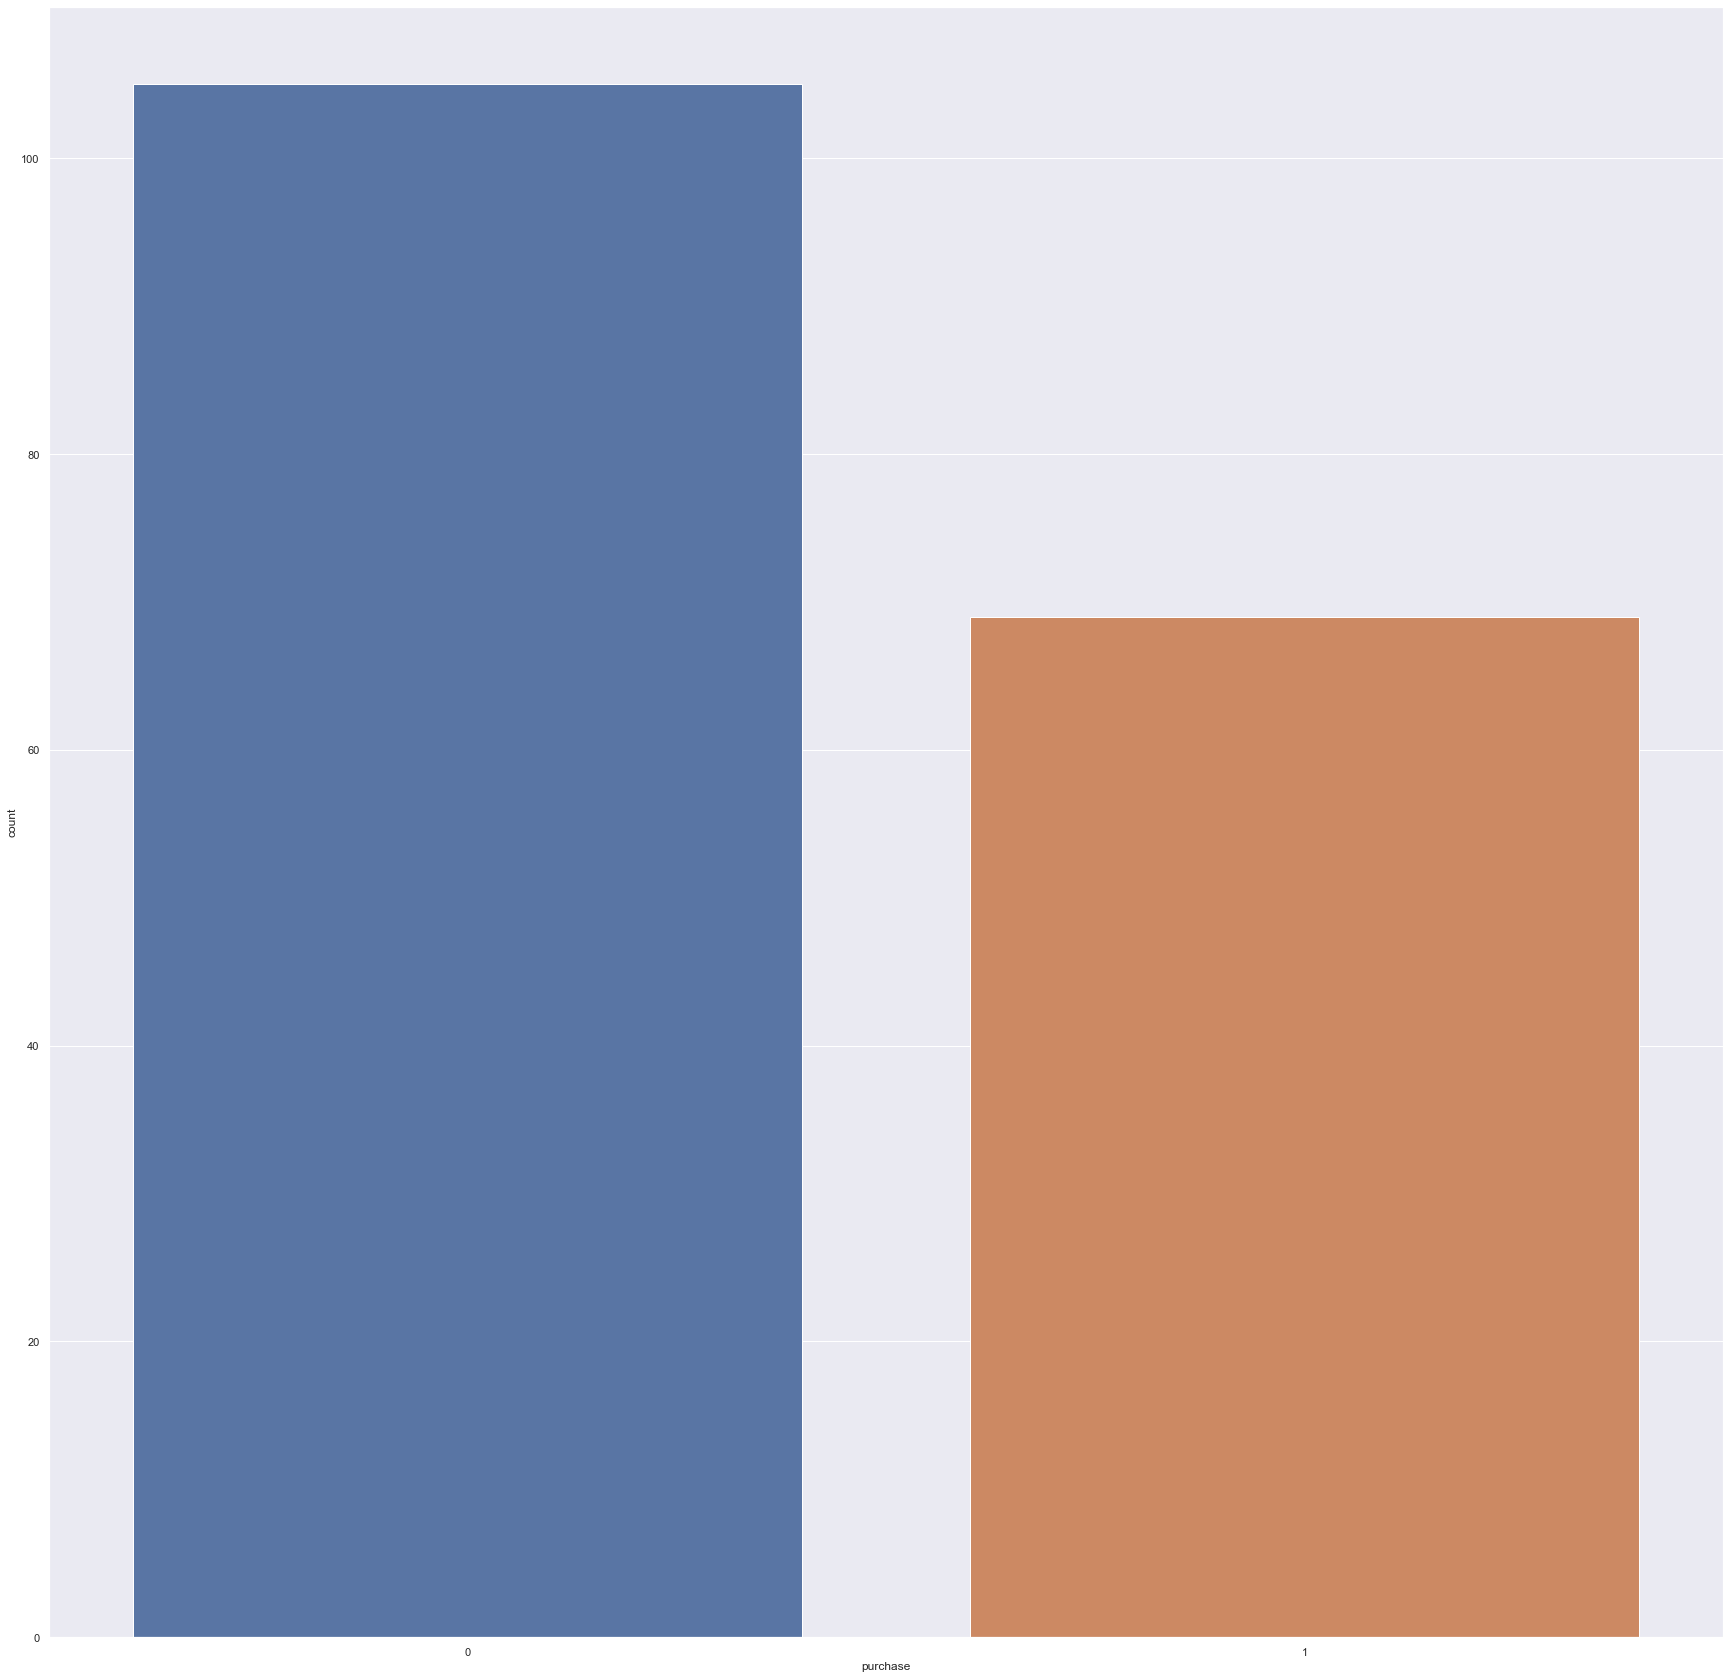

In [98]:
print(Counter(order_denorm_predict['purchase']))
sns.countplot(order_denorm_predict['purchase'])
plt.savefig('../reports/figures/purchase_distribution.png')

In [99]:
# Create weekday indicator
order_denorm_predict["day_of_week"] = order_denorm_predict["order_created_at_utc"].dt.weekday

In [100]:
order_denorm_predict["day_of_week"].value_counts()

4    46
2    39
0    33
1    30
3    26
Name: day_of_week, dtype: int64

Interestingly, no weekend purchases, so this store is not open on weekends?

<AxesSubplot:>

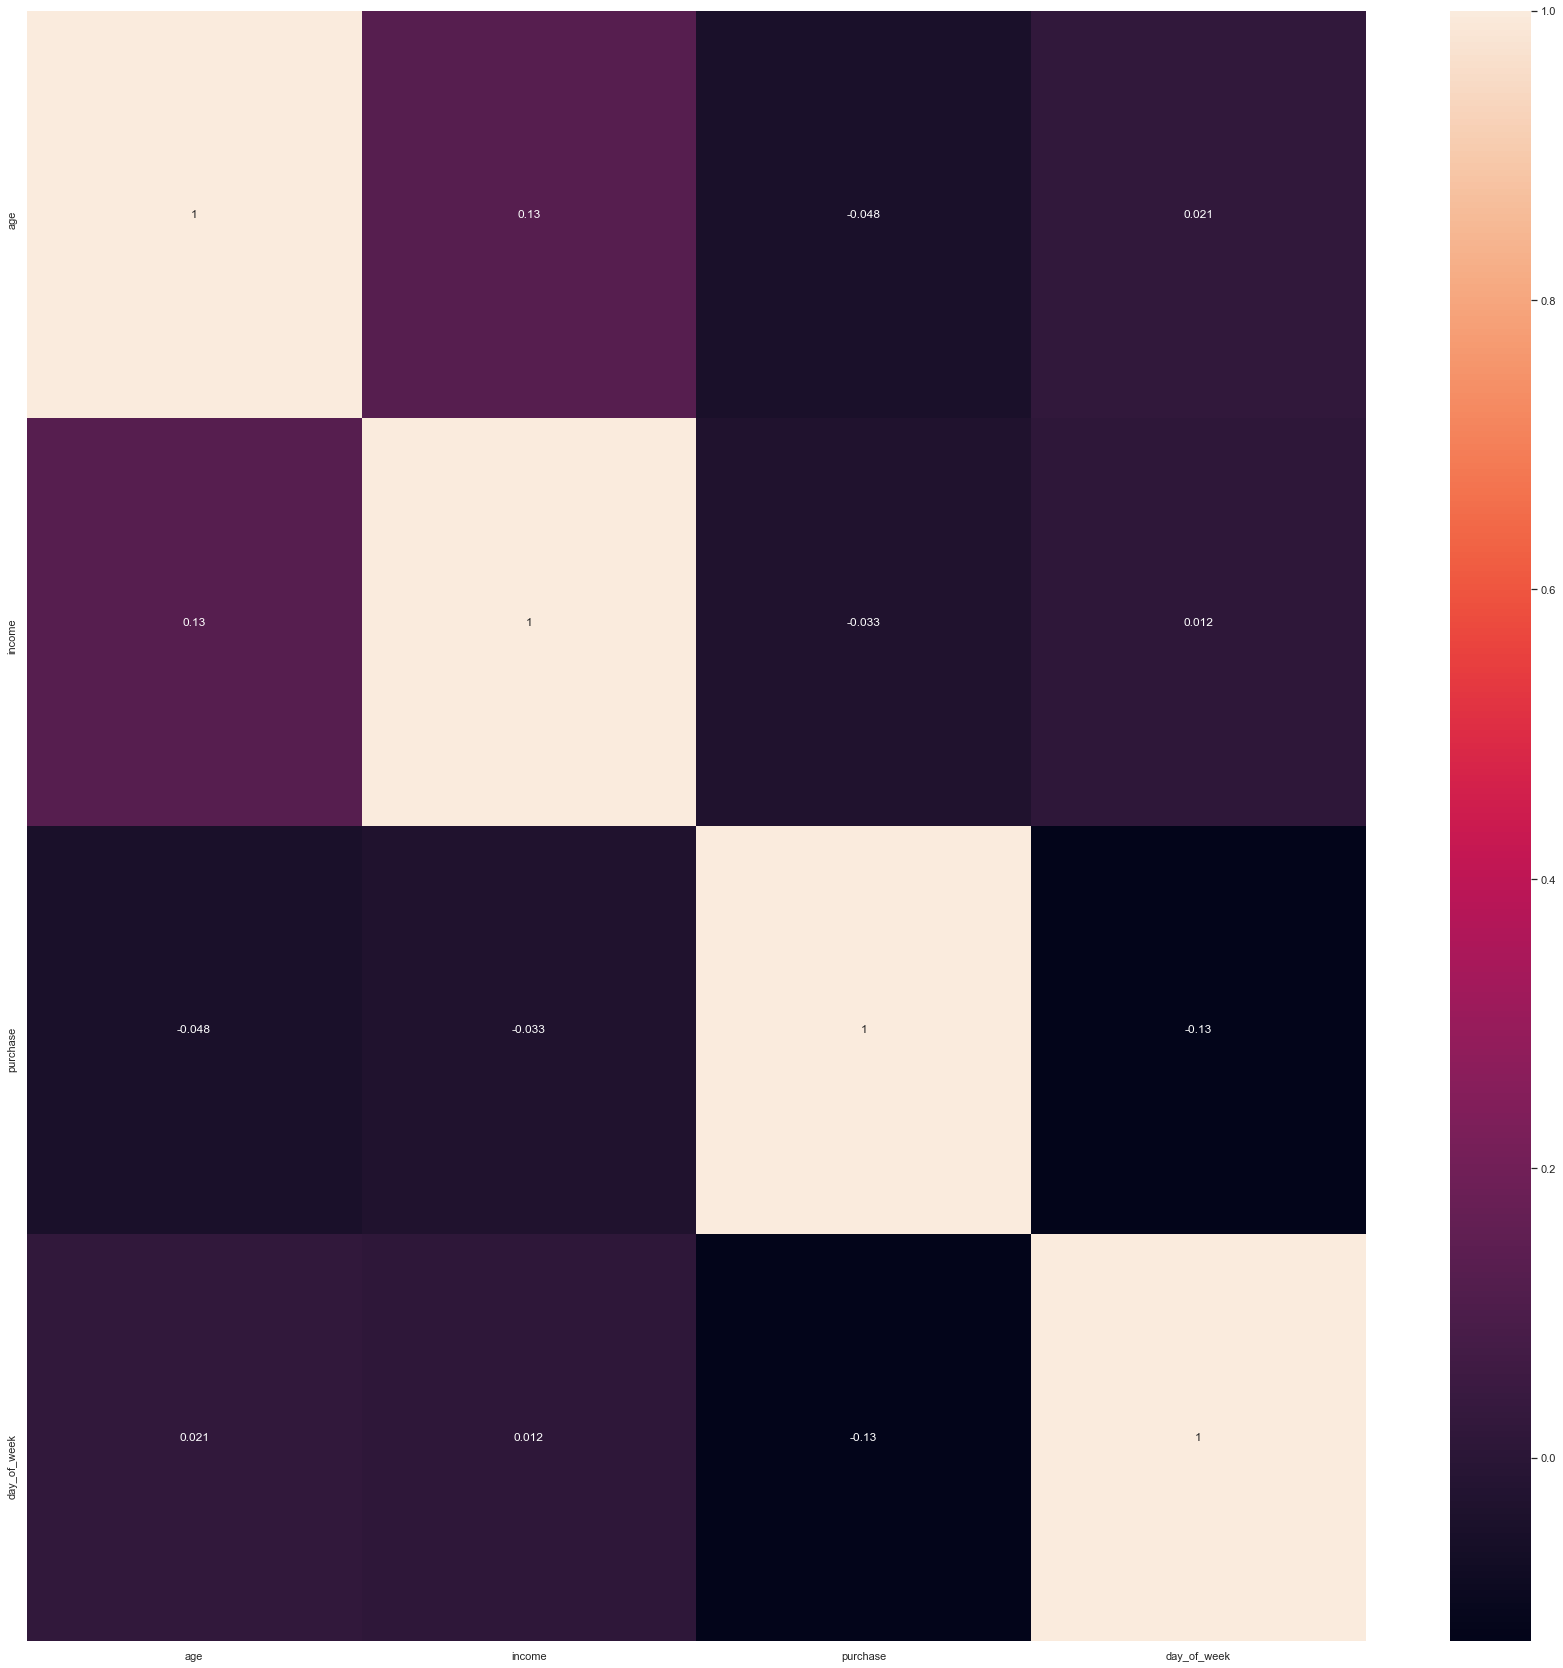

In [102]:
corrMatrix = order_denorm_predict.corr()
sns.set(rc={'figure.figsize':(30, 30)})
sns.heatmap(corrMatrix, annot=True)
plt.savefig('../reports/figures/orders_correlation_matrix.png')

In [104]:
# Encode categorical features
order_denorm_predict = pd.get_dummies(order_denorm_predict, columns = ['day_of_week','gender','group_name', 'customer_state', 'customer_country', 'device_type'])

In [105]:
order_denorm_predict.head()

,order_created_at_utc,age,income,product_title,purchase,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,gender_female,gender_male,group_name_AB_2021-04-20_1,group_name_Aspect's Team,group_name_Bender's Team,group_name_Big Papa's Familia,group_name_Big Papa's Winners,group_name_Bowser's Familia,group_name_Bowser's Team,group_name_Bowser's Winners,group_name_Bruise's Group,group_name_Bruise's Team,group_name_Bruise's Winners,group_name_Cannon's Familia,group_name_Cannon's Group,...,customer_state_AL,customer_state_BC,customer_state_BY,customer_state_CA,customer_state_CT,customer_state_Kharkivs'ka oblast,customer_state_MA,customer_state_MN,customer_state_NJ,customer_state_NY,customer_state_PA,customer_state_PR,customer_state_Qro.,customer_state_SK,customer_state_UP,customer_country_CA,customer_country_DE,customer_country_IN,customer_country_MK,customer_country_MX,customer_country_RS,customer_country_UA,customer_country_US,device_type_Desktop,device_type_Mobile
0,2021-04-26 10:27:48.058595+00:00,51,73000,Beam Blue Hoodie,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,2021-04-26 10:27:48.058595+00:00,51,73000,Beam Blue Hoodie,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,2021-04-28 13:21:45.829622+00:00,45,79000,Beam Blue Sweats,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,2021-04-27 17:29:40.519036+00:00,36,98000,Beam Blue Hoodie,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,2021-04-27 17:29:40.519036+00:00,36,98000,Beam Blue Hoodie,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


Encoded dates as days of week indicators, and blue beam purchase as binary indicator so will drop date and product title to avoid redundancies.

In [106]:
order_denorm_predict = order_denorm_predict.drop(["order_created_at_utc","product_title"], axis=1)

In [107]:
order_denorm_predict[order_denorm_predict.columns[1:]].corr()['purchase'][:].sort_values(ascending=False).to_frame()

,purchase
purchase,1.00000
gender_male,0.35524
device_type_Desktop,0.27386
group_name_Decay's Familia,0.25256
customer_state_CT,0.21218
...,...
customer_state_NJ,-0.16597
group_name_Mad Dog's Winners,-0.16597
day_of_week_4,-0.16627
device_type_Mobile,-0.27386


<a id=’section_3_3_1’></a>
### Models and feature selection

Illustrating a broad selection of model types

In [139]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score, roc_curve, accuracy_score

In [209]:
result_dict = {}

def summarize_classification(y_test,y_pred):
    
    acc = accuracy_score(y_test,y_pred,normalize=True)
    num_acc = accuracy_score(y_test,y_pred,normalize=False)
    
    prec = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1_score =  f1_score(y_test,y_pred)
    auc_score = roc_auc_score(y_test,y_pred)
    
    
    return{'Accuracy:': acc,
           'Accuracy_count:': num_acc,
           'Precision:': prec,
           'Recall:': recall,
           'F1_score:':F1_score,
           'AUC_ROC:':auc_score}

In [210]:
# Helper function to Build Model
def build_model(classifier_fn,
                name_of_y_col,
                df,test_frac=0.2,
                show_plot_auc=None):
    
    # Separating the  input features (X) and target variable (y)
    X = df.drop(name_of_y_col, axis=1)
    Y = df[name_of_y_col]
    
    # feature Scaling
    scale_x = StandardScaler()
    x = scale_x.fit_transform(X)
    
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
    
    model = classifier_fn(x_train,y_train)
    
    y_pred = model.predict(x_test)
    
    y_pred_train = model.predict(x_train)
    
    train_summary = summarize_classification(y_train,y_pred_train)
    test_summary = summarize_classification(y_test,y_pred)
    
    pred_result = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
    
    model_crosstab = pd.crosstab(pred_result.y_pred,pred_result.y_test)
    
    if show_plot_auc==True:
        plt.figure(figsize=(8,6))
        
        logit_roc_auc1 = roc_auc_score(y_train, model.predict(x_train))
        fpr1, tpr1, thresholds1 = roc_curve(y_train, model.predict_proba(x_train)[:,1])
        plt.plot(fpr1, tpr1, label='Class_Train (AUC = %0.2f)' % logit_roc_auc1)
            
        logit_roc_auc2 = roc_auc_score(y_test, model.predict(x_test))
        fpr2, tpr2, thresholds2 = roc_curve(y_test, model.predict_proba(x_test)[:,1])
        plt.plot(fpr2, tpr2,label='Class_Test (AUC = %0.2f)' % logit_roc_auc2)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic(ROC-AUC)')
        plt.legend(loc="lower right")
        plt.show()
        
    
    return{'training':train_summary,
          'test':test_summary,
          'confusion_matrix':model_crosstab
          }
          
# Helper function to compare the score of different Model.    
def compare_result():
    for key in result_dict:
        print('Classification: ',key)
        
        print()
        print('Training data:-')
        for score in result_dict[key]['training']:
            print(score,result_dict[key]['training'][score])
            
        print()
        print('Test Data:-')
        for score in result_dict[key]['test']:
            print(score,result_dict[key]['test'][score])
            
        print()

#### Logistic regression

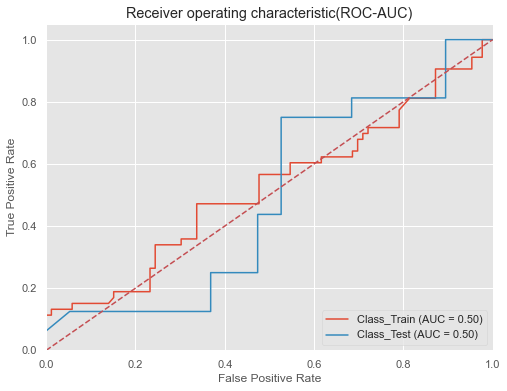

{'Purchase ~ Logistic': {'training': {'Accuracy:': 0.6187050359712231, 'Accuracy_count:': 86, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.5428571428571428, 'Accuracy_count:': 19, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0   1
y_pred        
0       19  16}}


In [127]:
def logistic_fn(x_train,y_train):
    model = LogisticRegression(solver='liblinear',random_state=12)
    model.fit(x_train,y_train)
    
    return model

result_dict['Purchase ~ Logistic'] = \
    build_model(logistic_fn,'purchase',order_denorm_predict,show_plot_auc=True)
print(result_dict)

This baseline model can pretty much not determine the difference between transactions that purchase the sweats ant those that do not - it's effectively a coin toss using this model

#### KNN

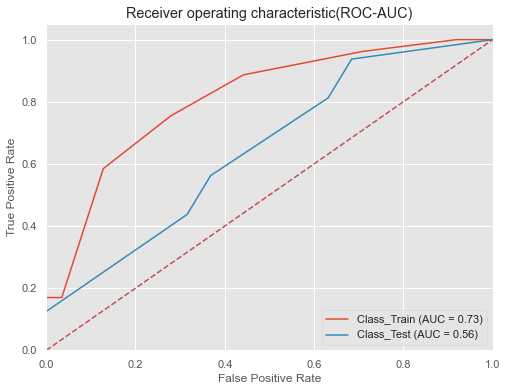

In [128]:
def knn_fn(x_train,y_train,n_neighbors=9,random_state=12):
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(x_train,y_train)
    
    return model
    
result_dict['Purchase ~ KNN'] = \
    build_model(knn_fn,'purchase',order_denorm_predict,show_plot_auc=True)

KNN performs better than logistic in training but poorly on holdout data, indicating model overfit. 

In [129]:
print(result_dict)

{'Purchase ~ Logistic': {'training': {'Accuracy:': 0.6187050359712231, 'Accuracy_count:': 86, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.5428571428571428, 'Accuracy_count:': 19, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0   1
y_pred        
0       19  16}, 'Purchase ~ KNN': {'training': {'Accuracy:': 0.762589928057554, 'Accuracy_count:': 106, 'Precision:': 0.7380952380952381, 'Recall:': 0.5849056603773585, 'F1_score:': 0.6526315789473685, 'AUC_ROC:': 0.7284993418165863}, 'test': {'Accuracy:': 0.5714285714285714, 'Accuracy_count:': 20, 'Precision:': 0.5384615384615384, 'Recall:': 0.4375, 'F1_score:': 0.4827586206896552, 'AUC_ROC:': 0.5608552631578947}, 'confusion_matrix': y_test   0  1
y_pred       
0       13  9
1        6  7}}


#### Naive Bayes

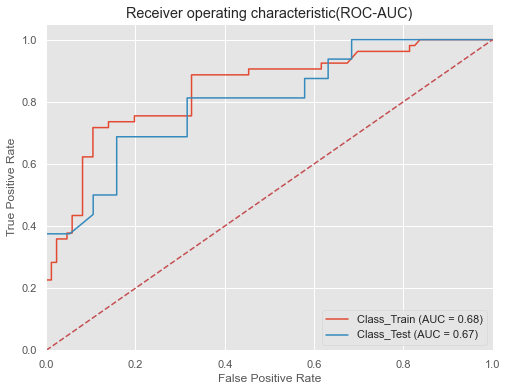

{'Purchase ~ Logistic': {'training': {'Accuracy:': 0.6187050359712231, 'Accuracy_count:': 86, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.5428571428571428, 'Accuracy_count:': 19, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0   1
y_pred        
0       19  16}, 'Purchase ~ KNN': {'training': {'Accuracy:': 0.762589928057554, 'Accuracy_count:': 106, 'Precision:': 0.7380952380952381, 'Recall:': 0.5849056603773585, 'F1_score:': 0.6526315789473685, 'AUC_ROC:': 0.7284993418165863}, 'test': {'Accuracy:': 0.5714285714285714, 'Accuracy_count:': 20, 'Precision:': 0.5384615384615384, 'Recall:': 0.4375, 'F1_score:': 0.4827586206896552, 'AUC_ROC:': 0.5608552631578947}, 'confusion_matrix': y_test   0  1
y_pred       
0       13  9
1        6  7}, 'Purchase ~ Naive_Bayes': {'training': {'Accuracy:': 0.7410071942446043, 'Accuracy_count:': 103, 'Precision:': 0.7931034482758621, 'Recall:': 0.4339622

In [130]:
def naive_bayes_fn(x_train,y_train,priors=None):
    
    model = GaussianNB(priors=priors)
    model.fit(x_train,y_train)
    
    return model
    
result_dict['Purchase ~ Naive_Bayes'] = \
    build_model(naive_bayes_fn,'purchase',order_denorm_predict,show_plot_auc=True)
print(result_dict)

Better than logistic and better than KNN on test set

In [131]:
pd.DataFrame.from_dict(result_dict)

,Purchase ~ Logistic,Purchase ~ KNN,Purchase ~ Naive_Bayes
training,"{'Accuracy:': 0.6187050359712231, 'Accuracy_co...","{'Accuracy:': 0.762589928057554, 'Accuracy_cou...","{'Accuracy:': 0.7410071942446043, 'Accuracy_co..."
test,"{'Accuracy:': 0.5428571428571428, 'Accuracy_co...","{'Accuracy:': 0.5714285714285714, 'Accuracy_co...","{'Accuracy:': 0.6857142857142857, 'Accuracy_co..."
confusion_matrix,y_test 0 1 y_pred 0 19 16,y_test 0 1 y_pred 0 13 9 1 ...,y_test 0 1 y_pred 0 17 9 1 ...


#### Random Forest

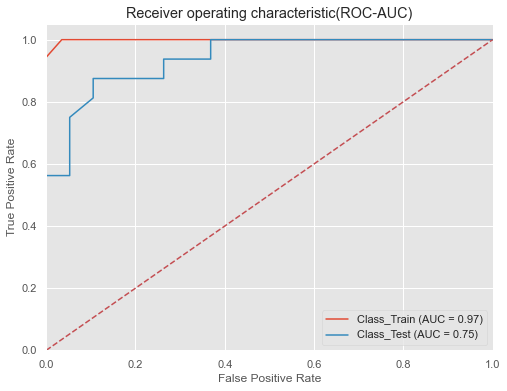

{'Purchase ~ Logistic': {'training': {'Accuracy:': 0.6187050359712231, 'Accuracy_count:': 86, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.5428571428571428, 'Accuracy_count:': 19, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0   1
y_pred        
0       19  16}, 'Purchase ~ KNN': {'training': {'Accuracy:': 0.762589928057554, 'Accuracy_count:': 106, 'Precision:': 0.7380952380952381, 'Recall:': 0.5849056603773585, 'F1_score:': 0.6526315789473685, 'AUC_ROC:': 0.7284993418165863}, 'test': {'Accuracy:': 0.5714285714285714, 'Accuracy_count:': 20, 'Precision:': 0.5384615384615384, 'Recall:': 0.4375, 'F1_score:': 0.4827586206896552, 'AUC_ROC:': 0.5608552631578947}, 'confusion_matrix': y_test   0  1
y_pred       
0       13  9
1        6  7}, 'Purchase ~ Naive_Bayes': {'training': {'Accuracy:': 0.7410071942446043, 'Accuracy_count:': 103, 'Precision:': 0.7931034482758621, 'Recall:': 0.4339622

In [132]:
def random_forest_fn(x_train,y_train):
    model = RandomForestClassifier(n_estimators= 50, max_depth = 15,random_state=12 )
    model.fit(x_train,y_train)
    
    return model
    
result_dict['Purchase ~ Random_Forest'] = \
    build_model(random_forest_fn,'purchase',order_denorm_predict,show_plot_auc=True)
print(result_dict)

Random Forest performs the best of our considered models but indicates some overfitting due to decreased performance on the holdout data. Would consider training on larger dataset, training using cross-validation, and/or some regularization method such as L1 or L2 regularization. L1 (Lasso) regularization also acts as a feature selection method. 

#### Feature selection

In [133]:
# Separating the  input features (X) and target variable (y)
X = order_denorm_predict.drop('purchase', axis=1)
Y = order_denorm_predict['purchase']

In [134]:
## Finding Important Features using ChiSq
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

dfObj[0].describe()

,0,1
1,1395.01008,income
8,17.54069,gender_male
96,11.10005,device_type_Mobile
34,10.65217,group_name_Decay's Familia
76,7.60870,customer_state_CT
...,...,...
54,0.08944,group_name_Reaper's Team
24,0.08944,group_name_Clink's Familia
10,0.05010,group_name_Aspect's Team
90,0.01553,customer_country_MK


count     97.00000
mean      16.69285
std      141.43045
min        0.01553
25%        0.65714
50%        1.52174
75%        3.04348
max     1395.01008
Name: 0, dtype: float64

In [135]:
drop_cols = dfObj[dfObj[0] < 5]

In [136]:
drop_cols = drop_cols[1].to_list()
print(drop_cols)

['age', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'gender_female', 'group_name_AB_2021-04-20_1', "group_name_Aspect's Team", "group_name_Bender's Team", "group_name_Big Papa's Familia", "group_name_Big Papa's Winners", "group_name_Bowser's Familia", "group_name_Bowser's Team", "group_name_Bowser's Winners", "group_name_Bruise's Group", "group_name_Bruise's Team", "group_name_Bruise's Winners", "group_name_Cannon's Familia", "group_name_Cannon's Group", "group_name_Cannon's Squad", "group_name_Cannon's Team", "group_name_Clink's Familia", "group_name_Clink's Group", "group_name_Cobra's Familia", "group_name_Cobra's Group", "group_name_Cobra's Team", "group_name_Colt's Winners", "group_name_Creep's Group", "group_name_Creep's Team", "group_name_Daemon's Winners", "group_name_Danny's Group", "group_name_Decay's Group", "group_name_Decay's Team", "group_name_Doom's Squad", "group_name_Doom's Winners", "group_name_Dracula's Group", "group_name_Drac

In [137]:
X.drop(drop_cols, axis=1, inplace=True)

[12:51:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'Accuracy:': 0.7714285714285715, 'Accuracy_count:': 27, 'Precision:': 0.8333333333333334, 'Recall:': 0.625, 'F1_score:': 0.7142857142857143, 'AUC_ROC:': 0.7598684210526316}


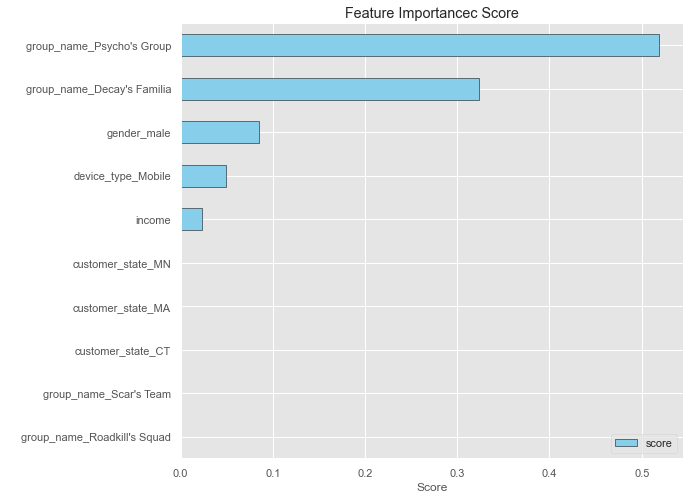

In [140]:
# Feature seelction using XGBoost
# feature Scaling
scale_x = StandardScaler()
x = scale_x.fit_transform(X)

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
model = XGBClassifier()
model.fit(x_train,y_train)

XGBoost_eval_metric_y_pred = model.predict(x_test)

print(summarize_classification(y_test,XGBoost_eval_metric_y_pred))

# Horizontal bar chart for feature Importance
feature_imp = pd.DataFrame({'feature':list(X.columns),'score':model.feature_importances_})
feature_imp.sort_values('score').plot(x='feature',y='score',kind='barh',color='skyblue',edgecolor='black',figsize=(9,8))

#plot formatting
plt.xlabel('Score')
plt.xticks()
plt.yticks()
plt.ylabel(' ')
plt.title('Feature Importancec Score')
plt.legend(loc="lower right")
plt.show();

Psycho's Group, Decay's Familia, male gender, mobile device transaction, and income are the top features for predicting purchase of the Blue Beam Sweats

## Repeat purchase

In [162]:
df.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,price,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-gsbrightbluesweatsmedium,pvariant-wegoodgreyteemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{'id': 'oli-NHz5q5rPAh4oj3QtZDfgQ3', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{'id': 'oli-E8hTJtpoz2uW5v75Bnm7Rd', 'price':...",2,"[110.00, 110.00]",1,0,0,0,0,0,0,0,0
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{'id': 'oli-MAucg88ir2tsPhjF9a98Np', 'price':...",1,[110.00],0,1,0,0,0,0,0,0,0
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{'id': 'oli-VJoPK9Jcao9objad3qxYMY', 'price':...",1,"[25.00, 25.00]",0,0,1,0,0,0,0,0,0
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.07912+00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{'id': 'oli-DxrhtnugrvEVqBsXgPwHtJ', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0


Make indicator for whether an order is a repeat customer purchase or not

In [167]:
df["repeat_purchase"] = np.where(df["row_num"] > 1, 1, 0)
df.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,price,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-gsbrightbluesweatsmedium,pvariant-wegoodgreyteemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium,repeat_purchase
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{'id': 'oli-NHz5q5rPAh4oj3QtZDfgQ3', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0,0
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{'id': 'oli-E8hTJtpoz2uW5v75Bnm7Rd', 'price':...",2,"[110.00, 110.00]",1,0,0,0,0,0,0,0,0,1
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{'id': 'oli-MAucg88ir2tsPhjF9a98Np', 'price':...",1,[110.00],0,1,0,0,0,0,0,0,0,0
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{'id': 'oli-VJoPK9Jcao9objad3qxYMY', 'price':...",1,"[25.00, 25.00]",0,0,1,0,0,0,0,0,0,0
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.07912+00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{'id': 'oli-DxrhtnugrvEVqBsXgPwHtJ', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0,0


Counter({0: 73, 1: 20})


<AxesSubplot:xlabel='repeat_purchase', ylabel='count'>

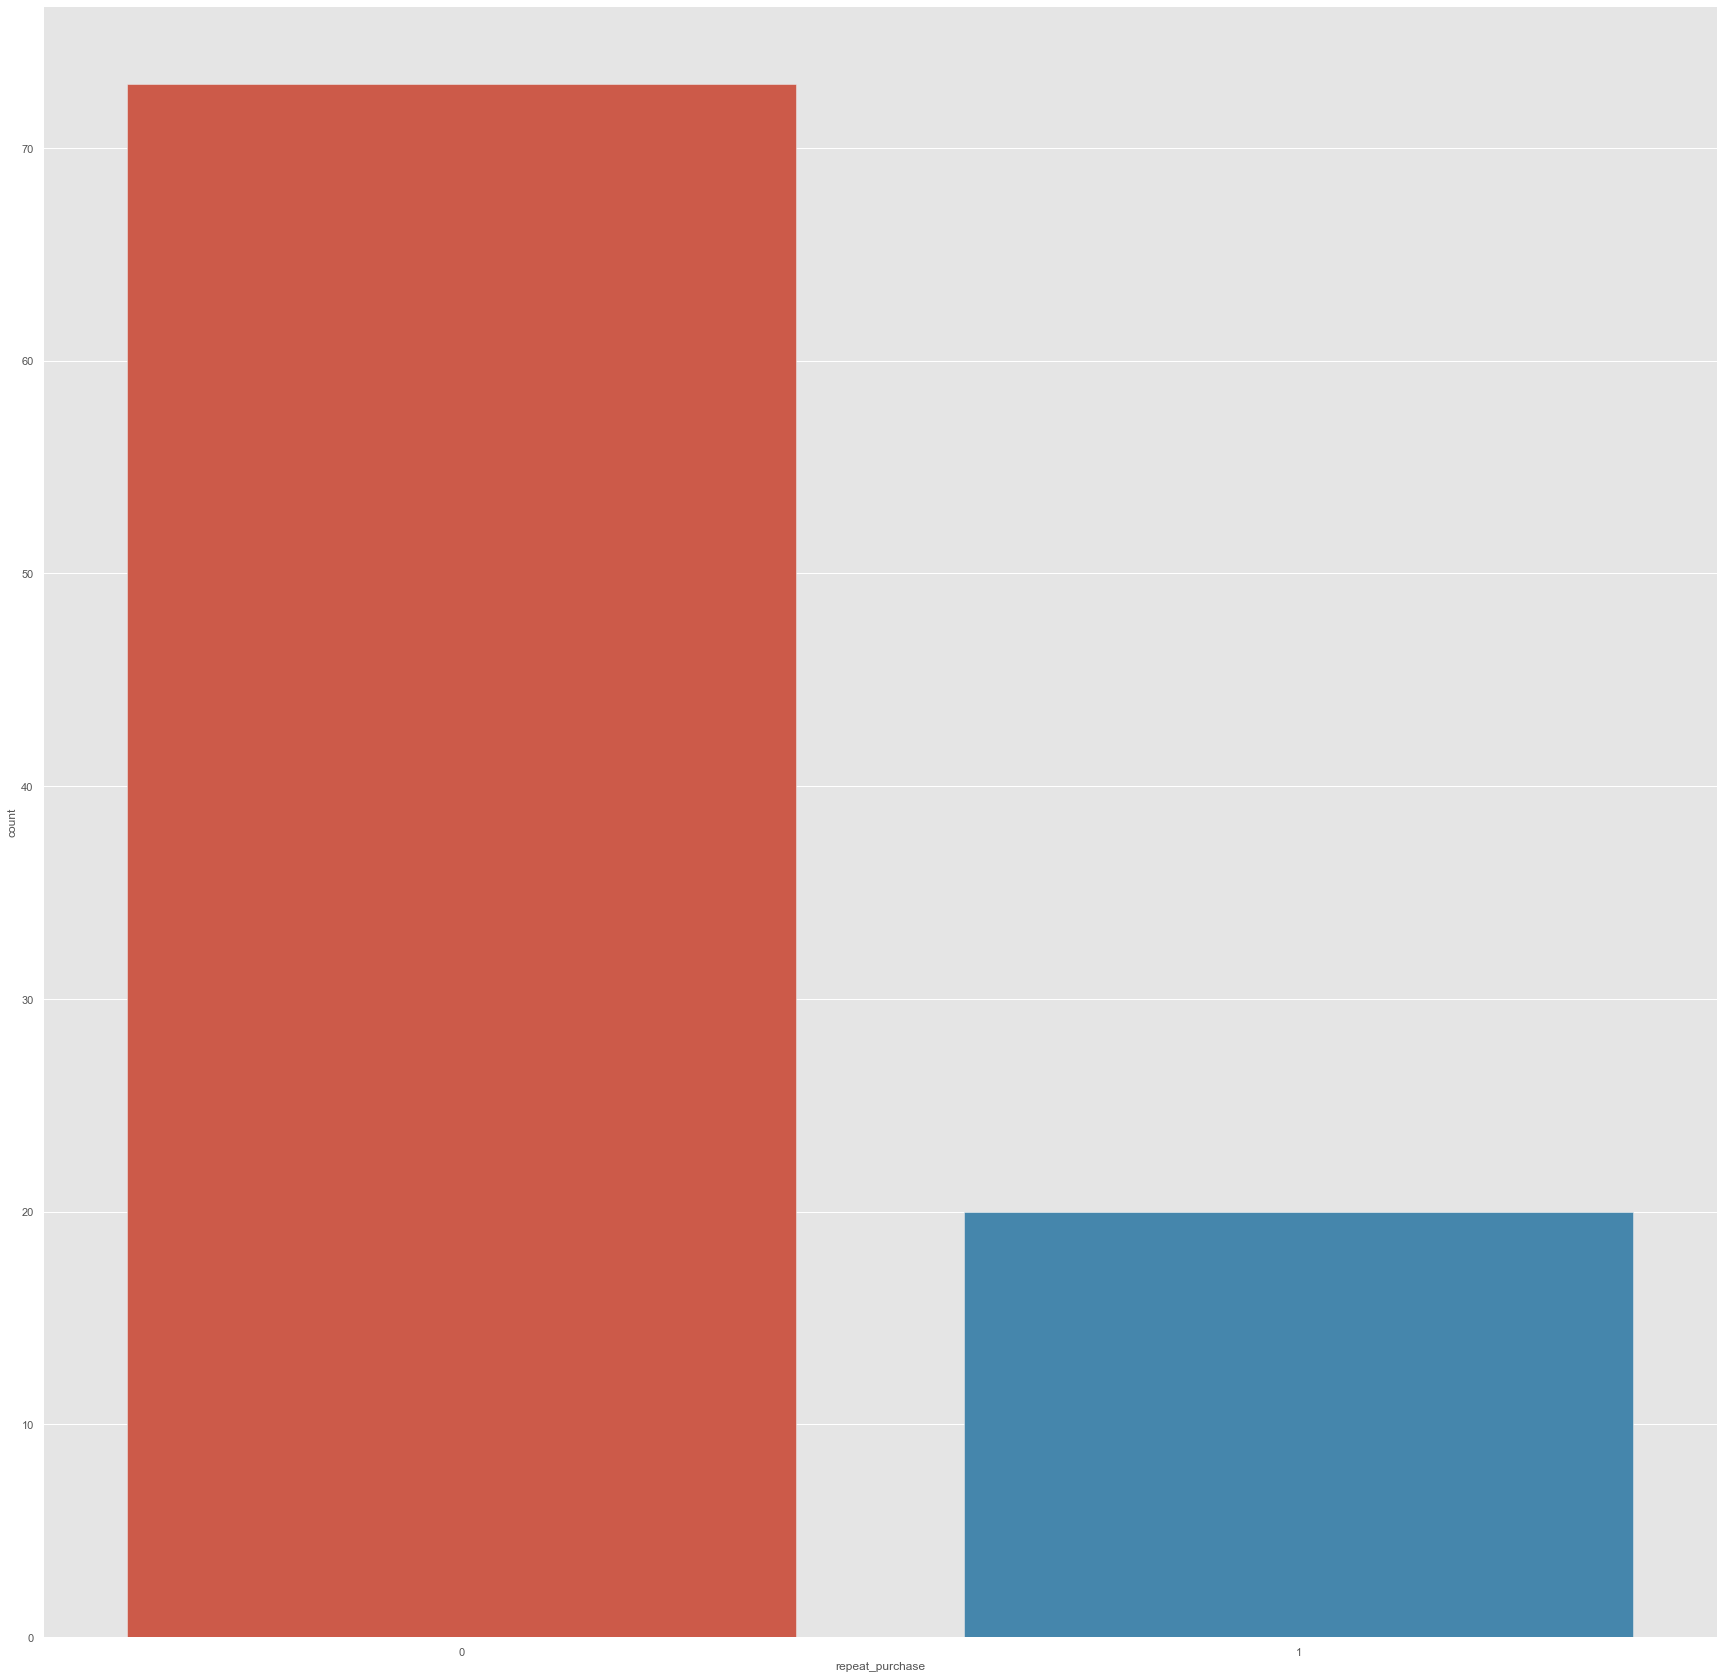

In [170]:
print(Counter(df['repeat_purchase']))
sns.countplot(df['repeat_purchase'])
plt.savefig('../reports/figures/repeat_purchase_distribution.png')

In [198]:
# # Keep columns for prediction of repeat purchase - keep order_total and drop other payment features since redundant, etc
# drop_cols = ["id", "order_number", "order_revision", "sub_total_amount", "tax_total_amount","shipping_total_amount","fee_total_amount", "charged_amount", "charge_refunded", "refunded_amount", "refunded_at_utc", "customer_id","group_id", "orderlineitems_jsonb", "price"]
# df_predict = df.drop(drop_cols, axis=1)
# df_predict.head()

In [199]:
# Keep columns for prediction of purchase - drop columns that could leak info, i.e. cost of item, etc
df_predict = df[["order_created_at_utc", "age", "gender", "income", "group_name", "customer_state", "customer_country", "device_type", "order_total_amount", "repeat_purchase"]]
df_predict.head()

,order_created_at_utc,age,gender,income,group_name,customer_state,customer_country,device_type,order_total_amount,repeat_purchase
0,2021-04-20 15:38:33.133957+00,51,female,73000,Sasquatch's Group,NY,US,Desktop,124.44000,0
1,2021-04-26 10:27:48.058595+00,51,female,73000,Cobra's Group,NY,US,Desktop,244.92000,1
2,2021-04-16 09:36:34.040838+00,24,female,39000,NaN,NaN,NaN,Desktop,113.51000,0
3,2021-04-26 18:05:00.426515+00,35,male,75000,Diablo's Winners,PA,US,Desktop,55.98000,0
4,2021-04-22 15:08:34.07912+00,53,female,97000,Rigs's Group,NY,US,Desktop,110.00000,0


In [200]:
# convert order date to datetime type
df_predict["order_created_at_utc"] = pd.to_datetime(df_predict["order_created_at_utc"])

In [201]:
# Create weekday indicator
df_predict["day_of_week"] = df_predict["order_created_at_utc"].dt.weekday

In [202]:
df_predict["day_of_week"].value_counts()

0    23
4    23
1    18
3    15
2    14
Name: day_of_week, dtype: int64

<AxesSubplot:>

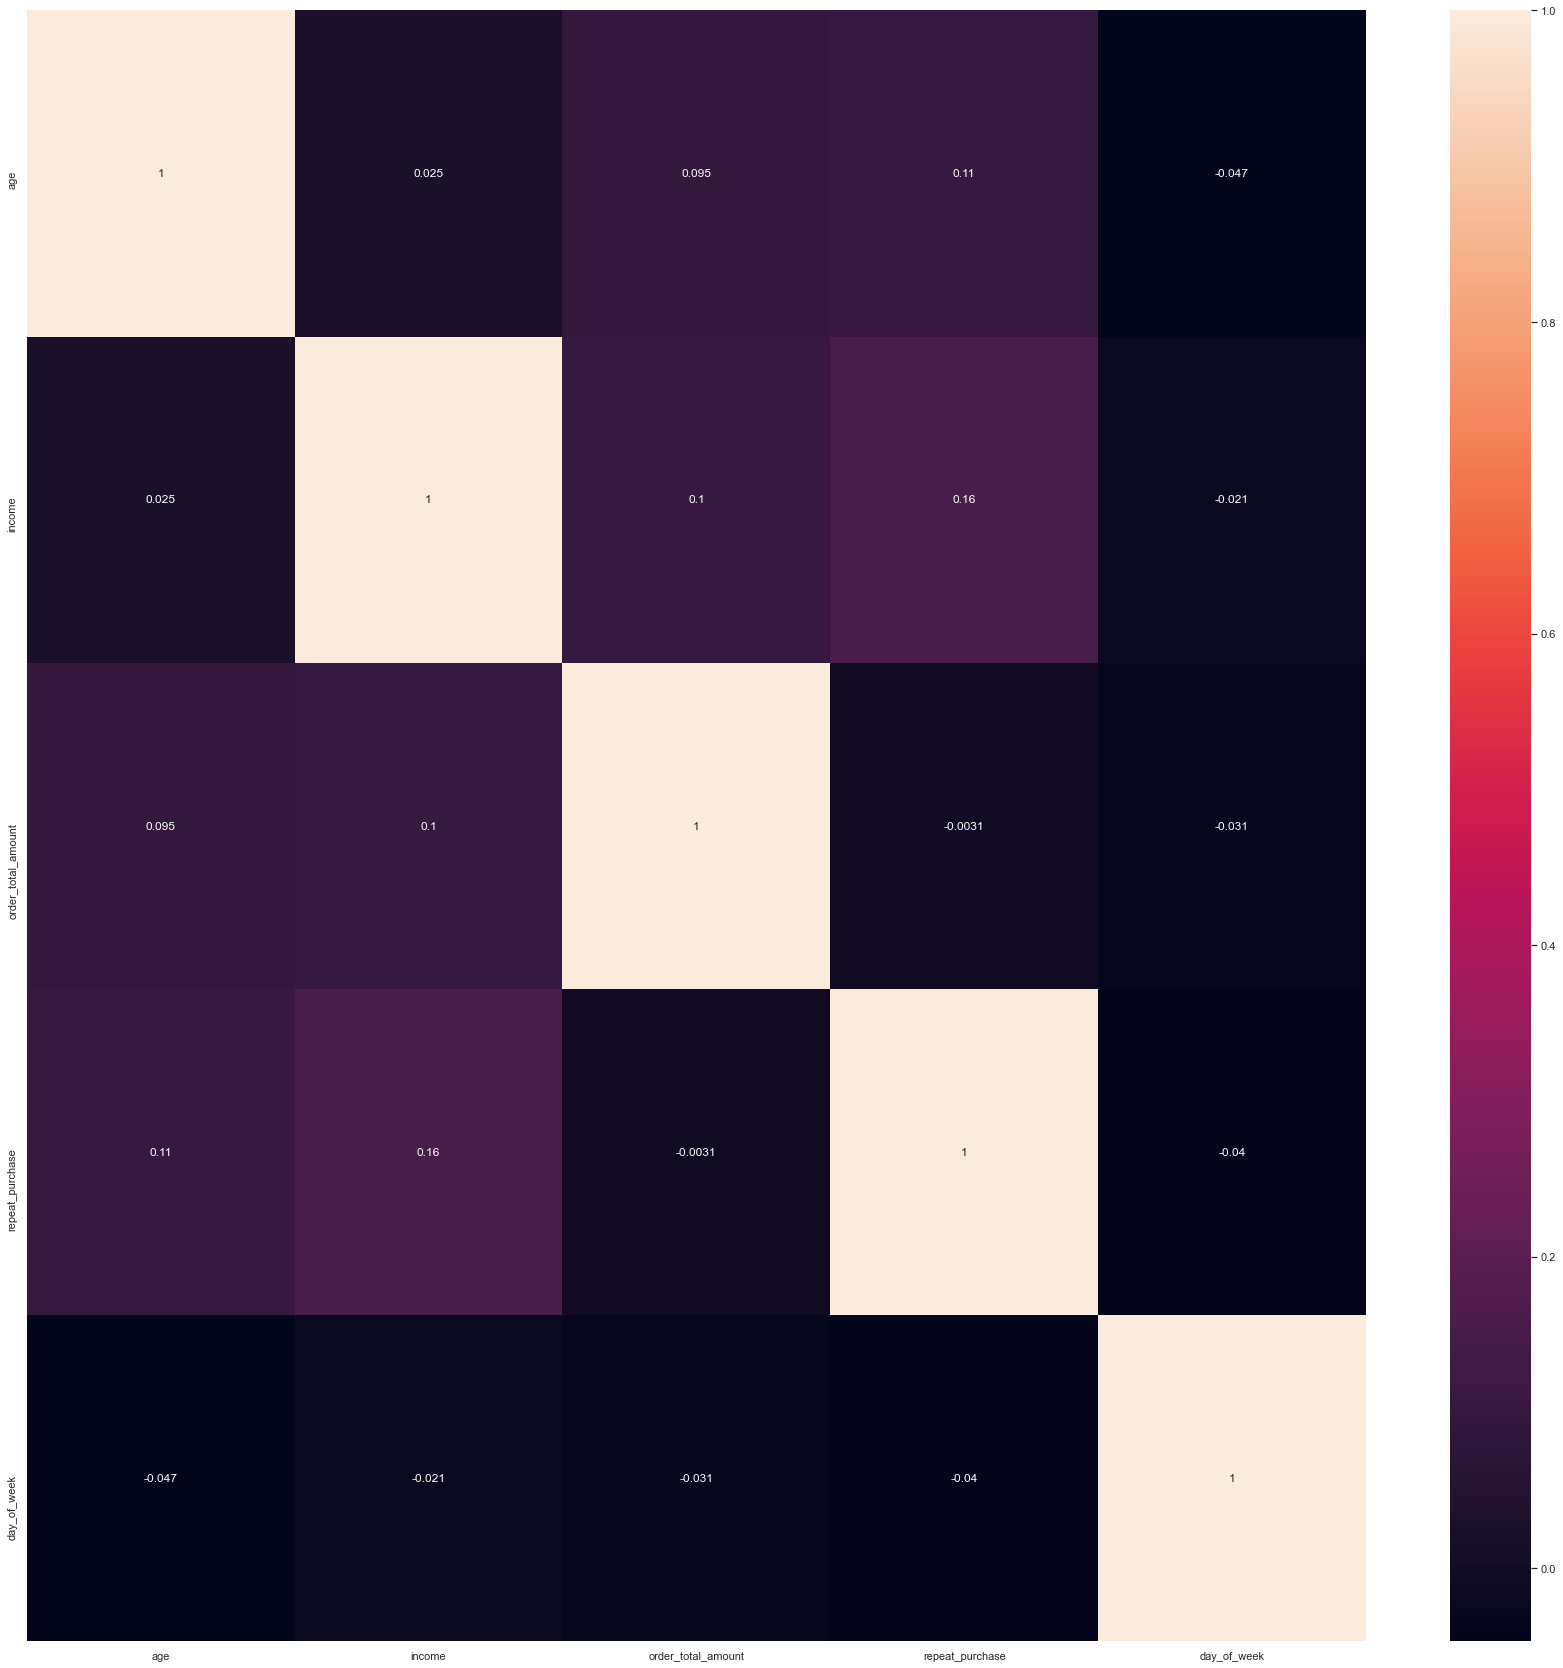

In [203]:
corrMatrix = df_predict.corr()
sns.set(rc={'figure.figsize':(30, 30)})
sns.heatmap(corrMatrix, annot=True)
plt.savefig('../reports/figures/repeat_purchase_correlation_matrix.png')

In [204]:
# Encode categorical features
df_predict = pd.get_dummies(df_predict, columns = ['day_of_week','gender','group_name', 'customer_state', 'customer_country', 'device_type'])

In [205]:
df_predict.head()

,order_created_at_utc,age,income,order_total_amount,repeat_purchase,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,gender_female,gender_male,group_name_AB_2021-04-20_1,group_name_Aspect's Team,group_name_Bender's Team,group_name_Big Papa's Familia,group_name_Big Papa's Winners,group_name_Bowser's Familia,group_name_Bowser's Team,group_name_Bowser's Winners,group_name_Bruise's Group,group_name_Bruise's Team,group_name_Bruise's Winners,group_name_Cannon's Familia,group_name_Cannon's Group,...,customer_state_AL,customer_state_BC,customer_state_BY,customer_state_CA,customer_state_CT,customer_state_Kharkivs'ka oblast,customer_state_MA,customer_state_MN,customer_state_NJ,customer_state_NY,customer_state_PA,customer_state_PR,customer_state_Qro.,customer_state_SK,customer_state_UP,customer_country_CA,customer_country_DE,customer_country_IN,customer_country_MK,customer_country_MX,customer_country_RS,customer_country_UA,customer_country_US,device_type_Desktop,device_type_Mobile
0,2021-04-20 15:38:33.133957+00:00,51,73000,124.44000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,2021-04-26 10:27:48.058595+00:00,51,73000,244.92000,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2021-04-16 09:36:34.040838+00:00,24,39000,113.51000,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2021-04-26 18:05:00.426515+00:00,35,75000,55.98000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,2021-04-22 15:08:34.079120+00:00,53,97000,110.00000,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


Encoded dates as days of week indicators so will drop date to avoid redundancies.

In [206]:
df_predict = df_predict.drop(["order_created_at_utc"], axis=1, errors="ignore")

In [207]:
df_predict[df_predict.columns[1:]].corr()['repeat_purchase'][:].sort_values(ascending=False).to_frame()

,repeat_purchase
repeat_purchase,1.00000
group_name_Decay's Team,0.19918
group_name_pdf,0.19918
group_name_Cobra's Group,0.19918
group_name_Creep's Squad,0.19918
...,...
group_name_Reaper's Team,-0.07760
customer_state_NY,-0.09174
group_name_Decay's Familia,-0.09556
customer_country_US,-0.13972


Let's use same prediction models we tested above in [Models and feature selection](#section_3_3_1)

### Models and feature selection

#### Logistic regression

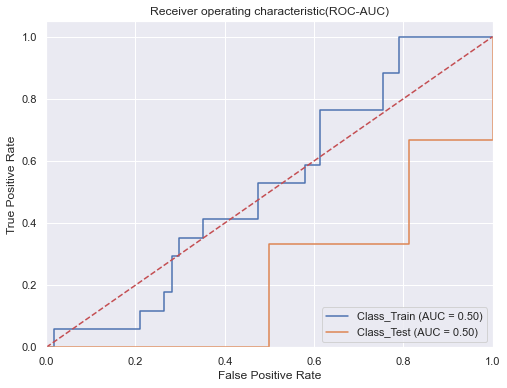

{'Repeat Purchase ~ Logistic': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}}


In [211]:
def logistic_fn(x_train,y_train):
    model = LogisticRegression(solver='liblinear',random_state=12)
    model.fit(x_train,y_train)
    
    return model

result_dict['Repeat Purchase ~ Logistic'] = \
    build_model(logistic_fn,'repeat_purchase',df_predict,show_plot_auc=True)
print(result_dict)

This baseline model can pretty much not determine the difference between transactions that are repeat purchases and not

#### KNN

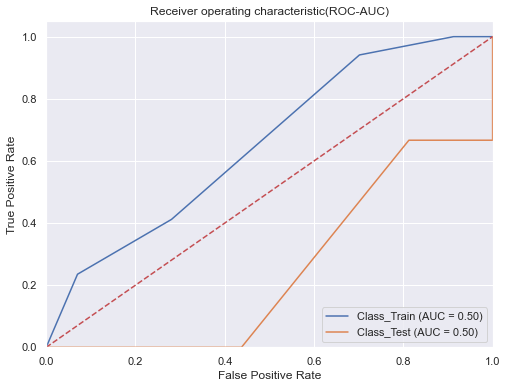

In [212]:
def knn_fn(x_train,y_train,n_neighbors=9,random_state=12):
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(x_train,y_train)
    
    return model
    
result_dict['Repeat Purchase ~ KNN'] = \
    build_model(knn_fn,'repeat_purchase',df_predict,show_plot_auc=True)

In [213]:
print(result_dict)

{'Repeat Purchase ~ Logistic': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}, 'Repeat Purchase ~ KNN': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}}


#### Naive Bayes

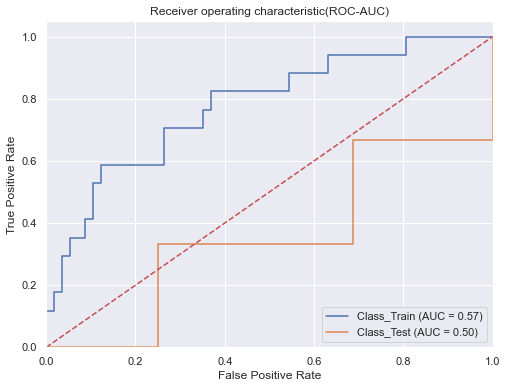

{'Repeat Purchase ~ Logistic': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}, 'Repeat Purchase ~ KNN': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}, 'Repeat Purchase ~ Naive_Bayes': {'training': {'Accuracy:': 0.7837837837837838, 'Accuracy_count:': 58, 'Precision:': 0.6, 'Recall:': 0.17647058823529413, 'F1_score:': 0.2727272727272727, 'AUC_ROC:': 0.5706914344685243}, 'test': {'Accuracy:': 0.8421052631578947, 

In [214]:
def naive_bayes_fn(x_train,y_train,priors=None):
    
    model = GaussianNB(priors=priors)
    model.fit(x_train,y_train)
    
    return model
    
result_dict['Repeat Purchase ~ Naive_Bayes'] = \
    build_model(naive_bayes_fn,'repeat_purchase',df_predict,show_plot_auc=True)
print(result_dict)

In [215]:
pd.DataFrame.from_dict(result_dict)

,Repeat Purchase ~ Logistic,Repeat Purchase ~ KNN,Repeat Purchase ~ Naive_Bayes
training,"{'Accuracy:': 0.7702702702702703, 'Accuracy_co...","{'Accuracy:': 0.7702702702702703, 'Accuracy_co...","{'Accuracy:': 0.7837837837837838, 'Accuracy_co..."
test,"{'Accuracy:': 0.8421052631578947, 'Accuracy_co...","{'Accuracy:': 0.8421052631578947, 'Accuracy_co...","{'Accuracy:': 0.8421052631578947, 'Accuracy_co..."
confusion_matrix,y_test 0 1 y_pred 0 16 3,y_test 0 1 y_pred 0 16 3,y_test 0 1 y_pred 0 16 3


#### Random Forest

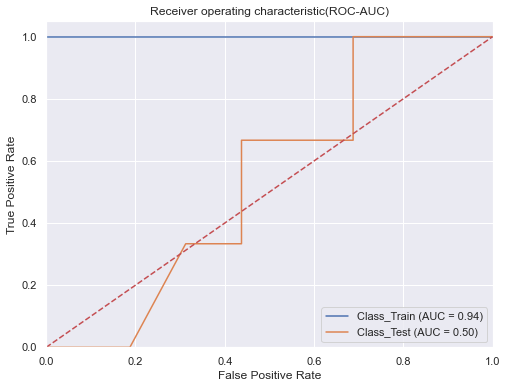

{'Repeat Purchase ~ Logistic': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}, 'Repeat Purchase ~ KNN': {'training': {'Accuracy:': 0.7702702702702703, 'Accuracy_count:': 57, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'test': {'Accuracy:': 0.8421052631578947, 'Accuracy_count:': 16, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.5}, 'confusion_matrix': y_test   0  1
y_pred       
0       16  3}, 'Repeat Purchase ~ Naive_Bayes': {'training': {'Accuracy:': 0.7837837837837838, 'Accuracy_count:': 58, 'Precision:': 0.6, 'Recall:': 0.17647058823529413, 'F1_score:': 0.2727272727272727, 'AUC_ROC:': 0.5706914344685243}, 'test': {'Accuracy:': 0.8421052631578947, 

In [222]:
def random_forest_fn(x_train,y_train):
    model = RandomForestClassifier(n_estimators= 10, max_depth = 15,random_state=12 , max_features="auto")
    model.fit(x_train,y_train)
    
    return model
    
result_dict['Repeat Purchase ~ Random_Forest'] = \
    build_model(random_forest_fn,'repeat_purchase',df_predict,show_plot_auc=True)
print(result_dict)

Random Forest performs the best of our considered models but it's very much overfitting due to decreased performance on the holdout data. Would consider training on larger dataset, training using cross-validation, and/or some regularization method such as L1 or L2 regularization. L1 (Lasso) regularization also acts as a feature selection method. 

#### Feature selection

In [223]:
# Separating the  input features (X) and target variable (y)
X = df_predict.drop('repeat_purchase', axis=1)
Y = df_predict['repeat_purchase']

In [224]:
## Finding Important Features using ChiSq
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

dfObj[0].describe()

,0,1
1,16151.42367,income
56,3.65000,group_name_Ratchet's Squad
72,3.65000,group_name_Sasquatch's Team
24,3.65000,group_name_Cannon's Team
31,3.65000,group_name_Creep's Group
...,...,...
7,0.23061,day_of_week_4
101,0.08682,device_type_Mobile
2,0.08402,order_total_amount
100,0.01286,device_type_Desktop


count     102.00000
mean      159.19112
std      1599.14525
min         0.00005
25%         0.27397
50%         0.27397
75%         0.96199
max     16151.42367
Name: 0, dtype: float64

In [225]:
drop_cols = dfObj[dfObj[0] < 1]

In [226]:
drop_cols = drop_cols[1].to_list()
print(drop_cols)

['order_total_amount', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'gender_female', 'group_name_AB_2021-04-20_1', "group_name_Aspect's Team", "group_name_Bender's Team", "group_name_Big Papa's Familia", "group_name_Big Papa's Winners", "group_name_Bowser's Familia", "group_name_Bowser's Team", "group_name_Bowser's Winners", "group_name_Bruise's Group", "group_name_Bruise's Team", "group_name_Cannon's Familia", "group_name_Cannon's Group", "group_name_Cannon's Squad", "group_name_Clink's Familia", "group_name_Clink's Group", "group_name_Cobra's Familia", "group_name_Cobra's Team", "group_name_Colt's Winners", "group_name_Daemon's Winners", "group_name_Decay's Familia", "group_name_Decay's Group", "group_name_Diablo's Winners", "group_name_Doom's Squad", "group_name_Doom's Winners", "group_name_Dracula's Group", "group_name_Dracula's Team", "group_name_Kraken's Squad", "group_name_Kraken's Winners", "group_name_Lynch's Familia", "group_name_Lynch'

In [227]:
X.drop(drop_cols, axis=1, inplace=True)

[14:53:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'Accuracy:': 0.631578947368421, 'Accuracy_count:': 12, 'Precision:': 0.0, 'Recall:': 0.0, 'F1_score:': 0.0, 'AUC_ROC:': 0.375}


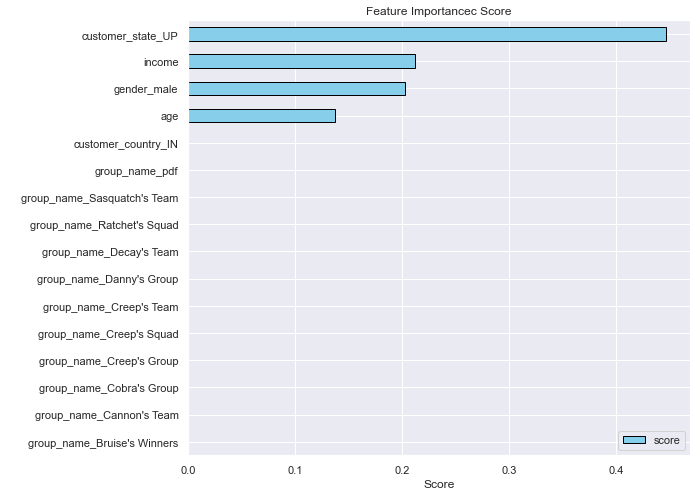

In [228]:
# Feature seelction using XGBoost
# feature Scaling
scale_x = StandardScaler()
x = scale_x.fit_transform(X)

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
model = XGBClassifier()
model.fit(x_train,y_train)

XGBoost_eval_metric_y_pred = model.predict(x_test)

print(summarize_classification(y_test,XGBoost_eval_metric_y_pred))

# Horizontal bar chart for feature Importance
feature_imp = pd.DataFrame({'feature':list(X.columns),'score':model.feature_importances_})
feature_imp.sort_values('score').plot(x='feature',y='score',kind='barh',color='skyblue',edgecolor='black',figsize=(9,8))

#plot formatting
plt.xlabel('Score')
plt.xticks()
plt.yticks()
plt.ylabel(' ')
plt.title('Feature Importancec Score')
plt.legend(loc="lower right")
plt.show();

Customer_state_UP, income, gender_male, and age are the drivers of whether a transaction is a repeat purchase or not. 

## Sales forecast

In [866]:
order_data.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,day_of_week,day_of_month,month
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00:00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{""id"": ""oli-NHz5q5rPAh4oj3QtZDfgQ3"", ""price"":...",1,1,20,4
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",2,0,26,4
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00:00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{""id"": ""oli-MAucg88ir2tsPhjF9a98Np"", ""price"":...",1,4,16,4
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00:00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{""id"": ""oli-VJoPK9Jcao9objad3qxYMY"", ""price"":...",1,0,26,4
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.079120+00:00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{""id"": ""oli-DxrhtnugrvEVqBsXgPwHtJ"", ""price"":...",1,3,22,4


In [862]:
order_data["order_created_at_utc"].min()

Timestamp('2021-04-16 00:05:23.058775+0000', tz='UTC')

In [863]:
order_data["order_created_at_utc"].max()

Timestamp('2021-05-28 22:51:49.713931+0000', tz='UTC')

In [867]:
# convert order date to datetime type
order_data["order_created_at_utc"] = pd.to_datetime(order_data["order_created_at_utc"])

In [868]:
order_data.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,day_of_week,day_of_month,month
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00:00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{""id"": ""oli-NHz5q5rPAh4oj3QtZDfgQ3"", ""price"":...",1,1,20,4
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00:00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{""id"": ""oli-E8hTJtpoz2uW5v75Bnm7Rd"", ""price"":...",2,0,26,4
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00:00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{""id"": ""oli-MAucg88ir2tsPhjF9a98Np"", ""price"":...",1,4,16,4
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00:00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{""id"": ""oli-VJoPK9Jcao9objad3qxYMY"", ""price"":...",1,0,26,4
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.079120+00:00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{""id"": ""oli-DxrhtnugrvEVqBsXgPwHtJ"", ""price"":...",1,3,22,4


In [875]:
df = order_data.drop(["age","income","row_num"], axis=1)

In [884]:
df = order_data.groupby([order_data["order_created_at_utc"].dt.date]).sum()
df.reset_index(inplace=True)
df.head()

,order_created_at_utc,order_revision,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,age,income,row_num,day_of_week,day_of_month,month
0,2021-04-16,14,2340,65.22500,108.45000,0,2626.55000,14,262655,0,0.00000,502,1155000,17,56,224,56
1,2021-04-19,10,2020,42.61000,84.40000,0,2248.30000,10,224830,0,0.00000,390,857000,11,0,190,40
2,2021-04-20,3,410,9.76000,20.18000,0,439.94000,3,43994,0,0.00000,113,234000,3,3,60,12
3,2021-04-21,4,950,20.42500,34.54000,0,1100.66000,4,110066,0,0.00000,130,240000,4,8,84,16
4,2021-04-22,5,590,26.18500,23.03000,0,643.31000,5,64331,0,0.00000,177,366000,6,15,110,20


In [886]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_created_at_utc   19 non-null     object 
 1   order_revision         19 non-null     int64  
 2   sub_total_amount       19 non-null     int64  
 3   tax_total_amount       19 non-null     float64
 4   shipping_total_amount  19 non-null     float64
 5   fee_total_amount       19 non-null     int64  
 6   order_total_amount     19 non-null     float64
 7   requires_payment       19 non-null     int64  
 8   charged_amount         19 non-null     int64  
 9   charge_refunded        19 non-null     int64  
 10  refunded_amount        19 non-null     float64
 11  age                    19 non-null     int64  
 12  income                 19 non-null     int64  
 13  row_num                19 non-null     int64  
 14  day_of_week            19 non-null     int64  
 15  day_of_m

In [887]:
# convert order date to datetime type
df["order_created_at_utc"] = pd.to_datetime(df["order_created_at_utc"])

In [888]:
# Create weekend indicator
df["day_of_week"] = df["order_created_at_utc"].dt.dayofweek
df["day_of_month"] = df["order_created_at_utc"].dt.day
df["month"] = df["order_created_at_utc"].dt.month

In [889]:
df.head()

,order_created_at_utc,order_revision,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,age,income,row_num,day_of_week,day_of_month,month
0,2021-04-16,14,2340,65.22500,108.45000,0,2626.55000,14,262655,0,0.00000,502,1155000,17,4,16,4
1,2021-04-19,10,2020,42.61000,84.40000,0,2248.30000,10,224830,0,0.00000,390,857000,11,0,19,4
2,2021-04-20,3,410,9.76000,20.18000,0,439.94000,3,43994,0,0.00000,113,234000,3,1,20,4
3,2021-04-21,4,950,20.42500,34.54000,0,1100.66000,4,110066,0,0.00000,130,240000,4,2,21,4
4,2021-04-22,5,590,26.18500,23.03000,0,643.31000,5,64331,0,0.00000,177,366000,6,3,22,4


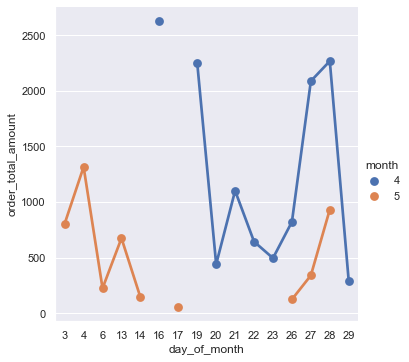

In [891]:
# Sales trend over the months and year
sns.factorplot(data = df, x ="day_of_month", y = "order_total_amount", hue = 'month')


## Customer social cluster

In [230]:
df.head()

,id,order_number,order_revision,order_created_at_utc,sub_total_amount,tax_total_amount,shipping_total_amount,fee_total_amount,order_total_amount,requires_payment,charged_amount,charge_refunded,refunded_amount,refunded_at_utc,customer_id,age,gender,income,group_id,group_name,customer_state,customer_country,device_type,orderlineitems_jsonb,row_num,price,pvariant-gsbrightbluehoodiemedium,pvariant-gsbrightbluehoodieextrasmall,pvariant-socksbundle-size,pvariant-truckerhatone-size,pvariant-gsbrightbluesweatsmedium,pvariant-wegoodgreyteemedium,pvariant-gsbrightbluesweatsextrasmall,pvariant-basicwhiteteemedium,pvariant-gsbrightbluebundlemedium,repeat_purchase
0,efd688aa-c021-4766-9721-83dd92710c63,2PBDJLI,1,2021-04-20 15:38:33.133957+00,110,9.76000,4.68000,0,124.44000,True,12444,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Sasquatch's Group,NY,US,Desktop,"[{'id': 'oli-NHz5q5rPAh4oj3QtZDfgQ3', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0,0
1,ded54adc-adb0-4559-8d05-7c5440edd606,FCZXSMZ,1,2021-04-26 10:27:48.058595+00,220,15.40000,9.52000,0,244.92000,True,24492,False,NaN,NaN,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,51,female,73000,grp-ecae9171-f81d-4c25-9ab8-24b68702f4b9--good...,Cobra's Group,NY,US,Desktop,"[{'id': 'oli-E8hTJtpoz2uW5v75Bnm7Rd', 'price':...",2,"[110.00, 110.00]",1,0,0,0,0,0,0,0,0,1
2,4ac870d3-fe19-4203-ad28-6313793103b8,L3MSP59,1,2021-04-16 09:36:34.040838+00,110,0.00000,2.51000,0,113.51000,True,11351,False,NaN,NaN,20210316112735216-9KTsUNszerowF4A1X1NBhg,24,female,39000,grp-49abab43-13d6-439c-80de-3e98b4083758--good...,NaN,NaN,NaN,Desktop,"[{'id': 'oli-MAucg88ir2tsPhjF9a98Np', 'price':...",1,[110.00],0,1,0,0,0,0,0,0,0,0
3,aeaa4c4d-12e1-4016-bc47-30d08f00041c,CAHWWSMWOD,1,2021-04-26 18:05:00.426515+00,50,0.00000,5.98000,0,55.98000,True,5598,False,NaN,NaN,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,35,male,75000,grp-e49d32ee-df44-4e9e-a3ab-d6ab4b6988d9--good...,Diablo's Winners,PA,US,Desktop,"[{'id': 'oli-VJoPK9Jcao9objad3qxYMY', 'price':...",1,"[25.00, 25.00]",0,0,1,0,0,0,0,0,0,0
4,42dd34c1-f1ed-4f90-b7af-9261f423ebc9,FXPF4J2,1,2021-04-22 15:08:34.07912+00,110,0.00000,0.00000,0,110.00000,True,11000,False,NaN,NaN,20210317172029708-JQryUiA4jZKCdwq1p8voq,53,female,97000,grp-5228870e-24ec-4e97-a41c-db62394ed4f1--good...,Rigs's Group,NY,US,Desktop,"[{'id': 'oli-DxrhtnugrvEVqBsXgPwHtJ', 'price':...",1,[110.00],1,0,0,0,0,0,0,0,0,0


In [231]:
# Aggregate customer orders
# Using order revision as a count of rows (items) purchased by that customer
grouped_customers = df.groupby("customer_id").agg({"order_number": lambda x: x.nunique(), "order_revision": lambda x: x.count(), "order_total_amount": lambda x: x.sum(), "age":"first","gender":"first","income":"first","customer_state":"first","customer_country":"first"})
grouped_customers.head()

,order_number,order_revision,order_total_amount,age,gender,income,customer_state,customer_country
customer_id,,,,,,,,
20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,2,369.36000,51,female,73000,NY,US
20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,113.51000,24,female,39000,None,None
20210317171023585-M2tZ3kjFMaTVmE4shqXxua,1,1,55.98000,35,male,75000,PA,US
20210317172029708-JQryUiA4jZKCdwq1p8voq,1,1,110.00000,53,female,97000,NY,US
20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,1,465.58000,37,female,96000,Qro.,MX


In [232]:
# Encode categorical features
grouped_customers = pd.get_dummies(grouped_customers, columns = ['gender','customer_state', 'customer_country'])

In [238]:
grouped_customers.reset_index(inplace=True)
grouped_customers.head()    

,customer_id,order_number,order_revision,order_total_amount,age,income,gender_female,gender_male,customer_state_AL,customer_state_BC,customer_state_BY,customer_state_CA,customer_state_CT,customer_state_Kharkivs'ka oblast,customer_state_MA,customer_state_MN,customer_state_NJ,customer_state_NY,customer_state_PA,customer_state_PR,customer_state_Qro.,customer_state_SK,customer_state_UP,customer_country_CA,customer_country_DE,customer_country_IN,customer_country_MK,customer_country_MX,customer_country_RS,customer_country_UA,customer_country_US
0,20210316012807791-Xc2t5uiAkLzvTPxjhtJJHQ,2,2,369.36000,51,73000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,20210316112735216-9KTsUNszerowF4A1X1NBhg,1,1,113.51000,24,39000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20210317171023585-M2tZ3kjFMaTVmE4shqXxua,1,1,55.98000,35,75000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,20210317172029708-JQryUiA4jZKCdwq1p8voq,1,1,110.00000,53,97000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,20210317223206213-NfzPJbS9UTFStXosGMDBZV,1,1,465.58000,37,96000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


Since k-means is a distance-based metric, it's important to scale features so that one feature with a very large scale (income) does not drive the algorithm

In [257]:
scaler = MinMaxScaler()
features = grouped_customers.drop("customer_id", axis=1)
scaled_features = scaler.fit_transform(features)

We'll use elbow method and within-cluster-sum-of-squares (sum of distances of observations from their cluster centroids) to determine best number of clusters

In [258]:
wcss=[]

# fit kmeans and compute wcss for a range of cluster values
for i in range(1,16): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
        
    kmeans.fit(scaled_features)

    wcss.append(kmeans.inertia_)
    

KMeans(n_clusters=1, random_state=0)

KMeans(n_clusters=2, random_state=0)

KMeans(n_clusters=3, random_state=0)

KMeans(n_clusters=4, random_state=0)

KMeans(n_clusters=5, random_state=0)

KMeans(n_clusters=6, random_state=0)

KMeans(n_clusters=7, random_state=0)

KMeans(random_state=0)

KMeans(n_clusters=9, random_state=0)

KMeans(n_clusters=10, random_state=0)

KMeans(n_clusters=11, random_state=0)

KMeans(n_clusters=12, random_state=0)

KMeans(n_clusters=13, random_state=0)

KMeans(n_clusters=14, random_state=0)

KMeans(n_clusters=15, random_state=0)

Text(0.5, 1.0, 'The Elbow Method Graph')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

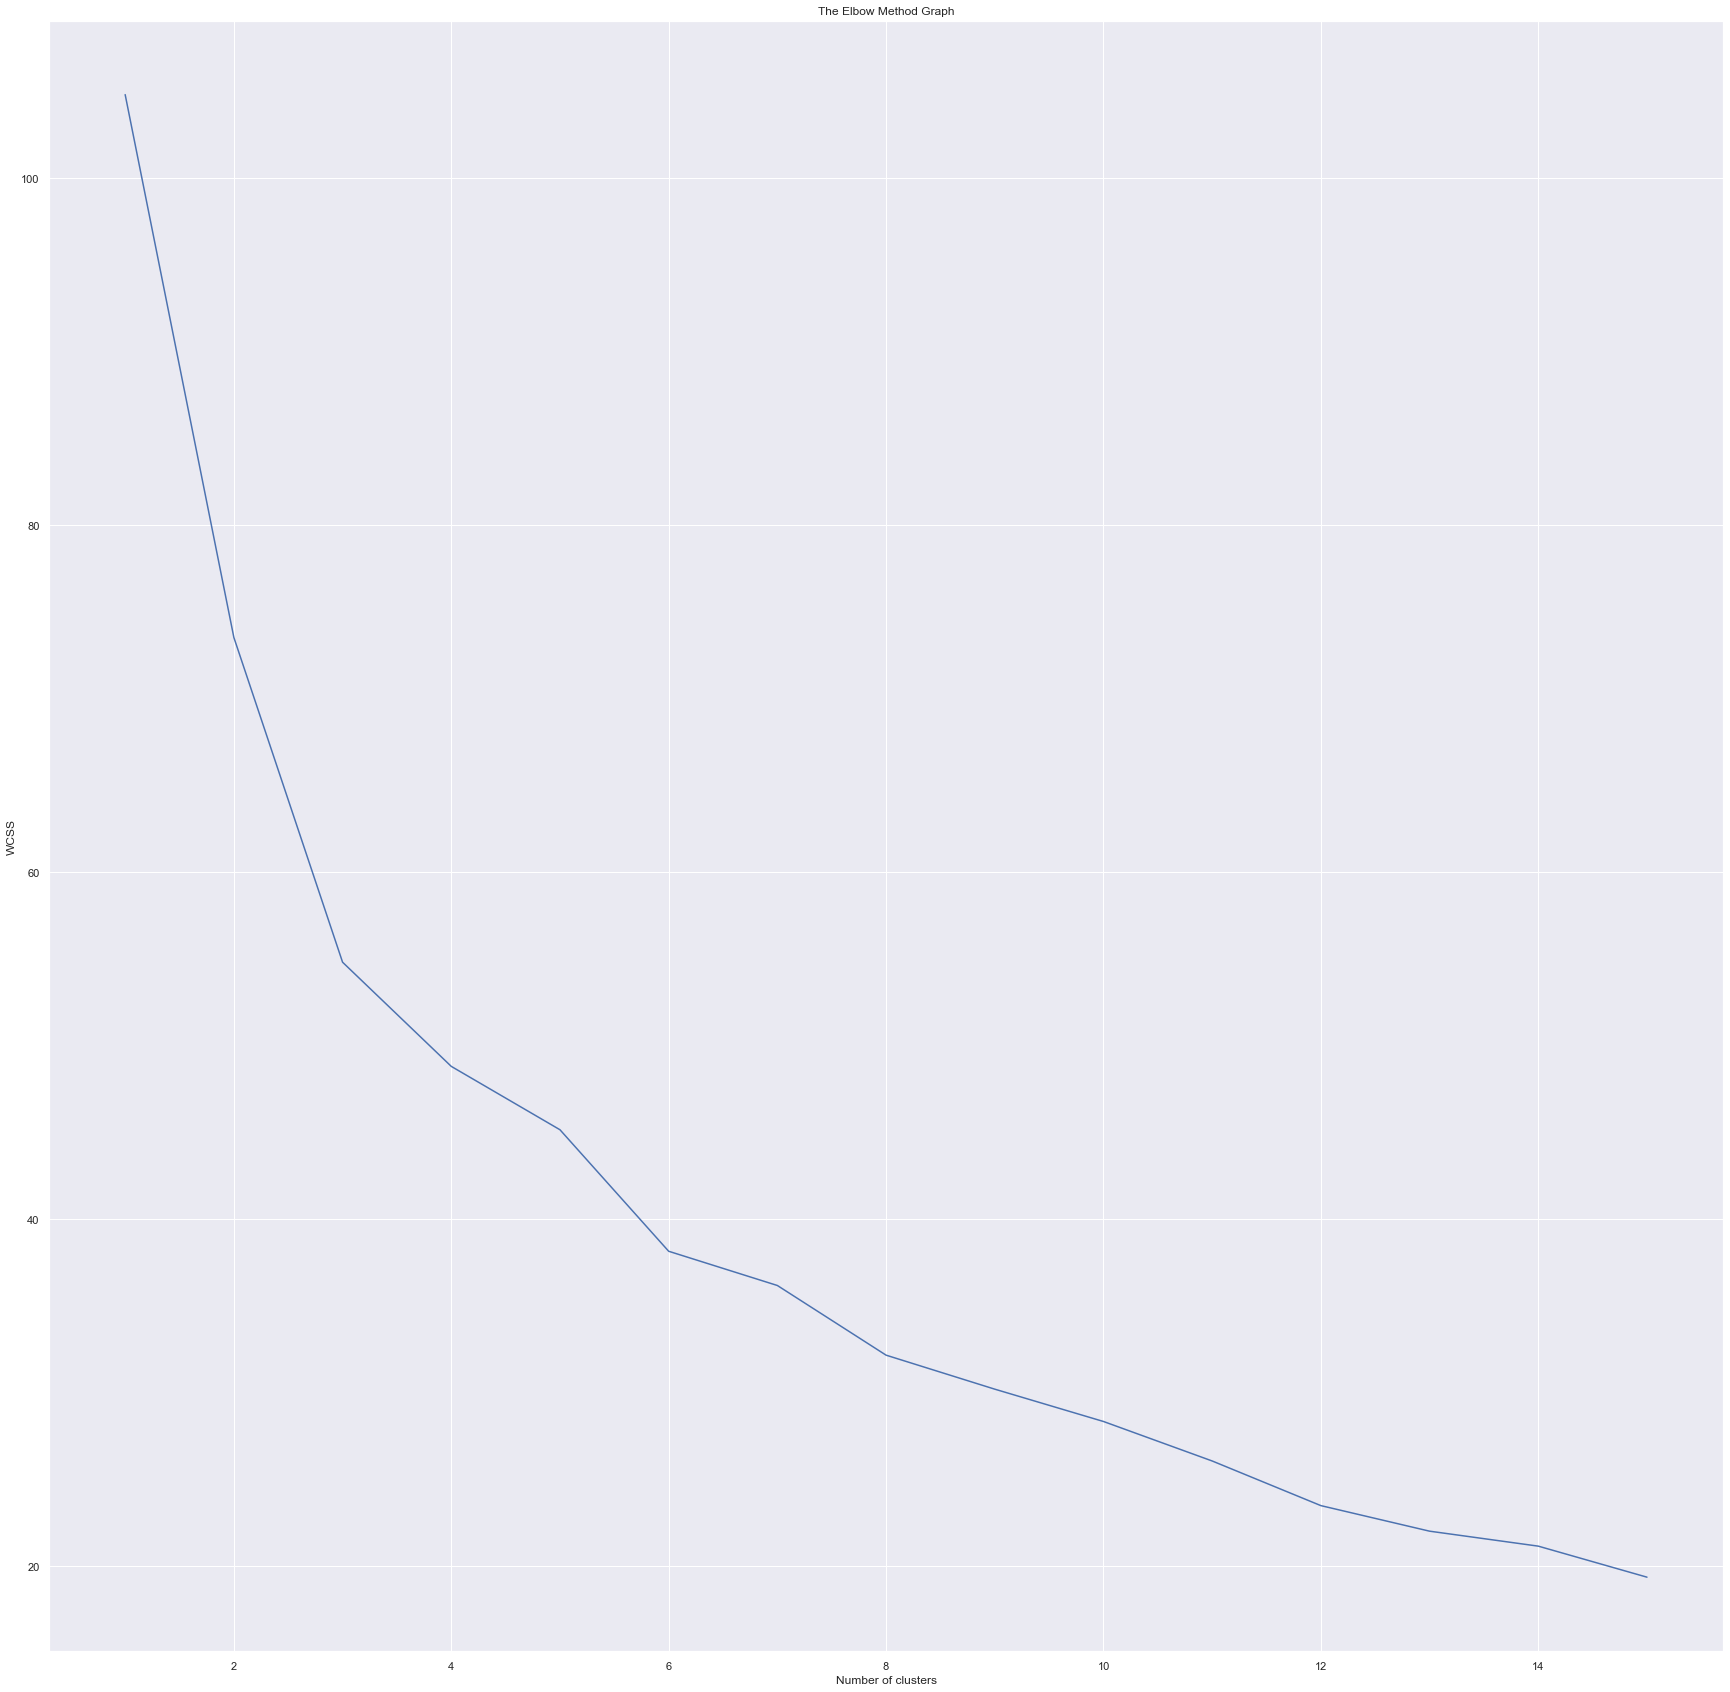

In [259]:
# Plot the elbow graph
plt.plot(range(1,16),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Seems like elbow around 6 clusters. 

In [260]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [261]:
n_clusters = 6
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [262]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [264]:
pipe.fit(features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=6, n_init=50,
                                         random_state=42))]))])

In [265]:
preprocessed_data = pipe["preprocessor"].transform(features)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.8403284558572204

This silhouette score indicates that observations are closer to the centroids in their assigned clusters than to other clusters

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Clustering results from Customer Order Data with 2 PCA components')

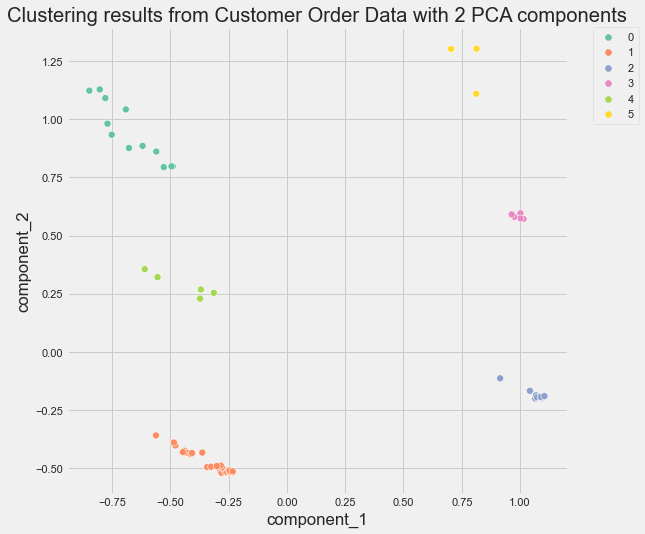

In [267]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(features),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
# pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    # style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from Customer Order Data with 2 PCA components"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.savefig('../reports/figures/customer_segmentation.png')
plt.show()

# Discussion/Next Steps

- I created this challenge in a full project to illustrate my work flow process and how I start most data science projects. 
- This project is started from a custom Cookiecutter template I created based off of my repeated experience building DS pipelines, and is pre-loaded with structure, tools, requirements, makefile, etc. that I feel lead to a consistent and efficient MVP. This template can be found here: [Jessica Rudd's cookiecutter data science template](https://github.com/JessicaRudd/A42-data-science) 
- This template also includes a [Data Science Project Checklist](https://github.com/JessicaRudd/A42-data-science/blob/main/ProjectChecklist.md) for quickly starting a DS project. 
- After building experimental code in a Jupyter Notebook (as in this challenge), I would then start modularizing the relevant pieces of this code into a package within the structure under 'src' folder as well as building out a test suite with pytest. 
- Package code could be pushed to an internal pypi server for sharing among colleagues and/or packaged into a Docker container for easy portabilty among systems. 
- I believe starting projects with this structure lends itself to good code and experiment habits and, hopefully, leads to smoother handoffs between data scientists and engineers, i.e. preventing models from dying in PowerPoint hell without ever being productionalized. :-) 